In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

time_epoch = 60
# 15 days 21600
epochs_per_batch = 4320

# hard coded nrows
df_all = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=35000000, skiprows=95000000)

df_all.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

df = df_all[(df_all['time'] > epochs_per_batch * time_epoch * 4) & (df_all['time'] <= epochs_per_batch * time_epoch * 5)]

df.index = df['time']
df.drop(columns=['time'],inplace=True)
df.head()

c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
1006504,0,C5736,445,C9570,N1327,6,1,46
1006504,0,C5997,N1317,C5736,445,6,1,46
1006504,0,C7032,N13485,C1707,N618,6,5,856
1006504,0,C7032,N19417,C1707,N618,6,5,856
1006504,0,C7046,N1315,C5736,445,6,1,46


In [7]:
df

,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
1036801,0,C11701,N13416,C1685,N2,6,6,1242
1036801,0,C11768,123,C528,123,17,1,96
1036801,0,C12598,N1154,C1707,N2,6,31,1769
1036801,0,C12598,N2731,C1707,N2,6,31,1769
1036801,0,C12598,N2735,C1707,N2,6,31,1769
1036801,0,C12598,N2743,C1707,N2,6,31,1769
1036801,0,C12598,N2744,C1707,N2,6,31,1769
1036801,0,C12598,N2746,C1707,N2,6,31,1769
1036801,0,C12598,N2747,C1707,N2,6,31,1769


In [5]:
# get all the host in the buckets we are interested in 

hosts = np.array(list(set(df_all[df_all['time'] <= 1500 * time_epoch / 4 ]['source computer'].values))) 

In [6]:
len(hosts)

2268

In [8]:
from sklearn.externals import joblib

hosts = joblib.load('host_15_days.pkl')
parameters = joblib.load('parameters_15_days.pkl')

In [10]:
from helper import group_scale_data, group_scale_data_batch

In [8]:
groupped_data, hosts, parameters = group_scale_data(df, size_of_bin_seconds=60,
                                                    addZeros=True, doScale=True, scaler='log', verbose=1, hosts=hosts)

A total of 4320 time epochs have been encountered
Done with 0 hosts out of 2268
Done with 226 hosts out of 2268
Done with 452 hosts out of 2268
Done with 678 hosts out of 2268
Done with 904 hosts out of 2268
Done with 1130 hosts out of 2268
Done with 1356 hosts out of 2268
Done with 1582 hosts out of 2268
Done with 1808 hosts out of 2268
Done with 2034 hosts out of 2268
Done with 2260 hosts out of 2268
Scaling...


In [11]:
#temp_df = df[(df.index > 1500 * time_epoch) & (df.index <= 2000 * time_epoch)]

groupped_data, hosts = group_scale_data_batch(df, parameters, setHosts=False, verbose=1)
groupped_data['epoch'] += 4320 * 4

Done with 0 hosts out of 2268
Done with 226 hosts out of 2268
Done with 452 hosts out of 2268
Done with 678 hosts out of 2268
Done with 904 hosts out of 2268
Done with 1130 hosts out of 2268
Done with 1356 hosts out of 2268
Done with 1582 hosts out of 2268
Done with 1808 hosts out of 2268
Done with 2034 hosts out of 2268
Done with 2260 hosts out of 2268


In [12]:
len(groupped_data) / len(hosts)

4320.0

In [14]:
from sklearn.externals import joblib

#joblib.dump(groupped_data, 'groupped_data_15_days_17281_21600.pkl')

['groupped_data_15_days_17281_21600.pkl']

In [ ]:
len(groupped_data1) / len(hosts)

In [ ]:
len(groupped_data) / len(hosts)

In [ ]:
print(len(hosts))
print(len(set(groupped_data['source computer'])))

In [2]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories
from kplusplus import KPlusPlus
import numpy as np
import pandas as pd

In [3]:
from sklearn.externals import joblib

test1 = joblib.load('groupped_data_15_days_00001_04320.pkl')
test2 = joblib.load('groupped_data_15_days_04321_08640.pkl')
test3 = joblib.load('groupped_data_15_days_08641_12960.pkl')
test4 = joblib.load('groupped_data_15_days_12961_17280.pkl')
groupped_data = pd.concat([test1, test2, test3, te409st4])
groupped_data1 = joblib.load('groupped_data_15_days_17281_21600.pkl')

In [ ]:
#joblib.dump(hosts,'hosts_60_500.pkl')
#hosts = joblib.load('hosts_60_500.pkl')

### Pooled Poisson

In [33]:
data = groupped_data.values[:, :2]
data1 = groupped_data1.values[:, :2]

In [22]:
lambdas = np.mean(groupped_data.values[:, :2], axis=0)

In [23]:
import scipy.stats.distributions
from math import log

def poisson(x, l):
    return_value = 1
    for x_i, l_i in zip(x, l):
        return_value *= scipy.stats.distributions.poisson.pmf(x_i, l_i)
    return return_value

def likelihood(lambdas, data):
    likelihood = 0
    intervals = len(data) / 20
    for i, x in enumerate(data):
        if i % intervals == 0:
            print('Done with', int(i/intervals),'/',20)
        total_x = poisson(x, lambdas)
        likelihood = likelihood + log(total_x)
    return likelihood/len(data)

In [ ]:
likelihood(lambdas, groupped_data.values[:, :2])

In [24]:
likelihood(lambdas, groupped_data1.values[:, :2])

Done with 0 / 20
Done with 1 / 20
Done with 2 / 20
Done with 3 / 20
Done with 4 / 20
Done with 5 / 20
Done with 6 / 20
Done with 7 / 20
Done with 8 / 20
Done with 9 / 20
Done with 10 / 20
Done with 11 / 20
Done with 12 / 20
Done with 13 / 20
Done with 14 / 20
Done with 15 / 20
Done with 16 / 20
Done with 17 / 20
Done with 18 / 20
Done with 19 / 20


-12.541260941272736

### Pooled Mixture of Poissons

In [ ]:
mixtures = 13

kplusplus = KPlusPlus(mixtures, groupped_data.values[:, :2], stochastic=True, stochastic_n_samples=10000)

kplusplus.init_centers(verbose=1)


In [ ]:
test = int(len(set(groupped_data['source computer'].values)))

# random initialization
onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, test, n_clusters=8, verbose=1, update_power=0.5)

plot_points(groupped_data.values[:, :2], onlineEM)

In [ ]:
data = groupped_data.values[:,[0,1,3]]

onlineEM.fit(data)

In [ ]:
plot_points(groupped_data.values[:, :2], onlineEM)

In [ ]:
# joblib.dump(onlineEM,'onlineEM_60_100_13.pkl')
onlineEM = joblib.load('onlineEM_60_500_13_host_specific.pkl')

In [ ]:
data1 = groupped_data1.values[:len(hosts)*100,[0,1,3]]

onlineEM.calculate_likelihood(data1) / len(data1)

### Per host mixture of Poissons

In [63]:
hosts = list(set(groupped_data['source computer']))

In [85]:
def likelihood_mixture_per_host(mixtures=3, groupped_data_train=groupped_data, groupped_data_test=groupped_data1):
    likelihoods = []
    likelihoods_for_hosts = []
    intervals = 50

    for i, host in enumerate(hosts):

        data_for_host_train = groupped_data_train[groupped_data_train['source computer'] == host]
        data_for_host_test = groupped_data_test[groupped_data_test['source computer'] == host]

        try:
            kplusplus = KPlusPlus(mixtures, data_for_host_train.values[:, :2], stochastic=False)

            kplusplus.init_centers(verbose=0)


            onlineEM_host = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, 1000, n_clusters=1, verbose=0, update_power=0.5)

            onlineEM_host.fit(data_for_host_train.values[:,[0,1,3]])

            
            likelihoods.append(onlineEM_host.calculate_likelihood(data_for_host_test.values[:,[0,1,3]]) / len(data_for_host_test))
            print(i, sum(likelihoods) / len(likelihoods))
            likelihoods_for_hosts.append(host)
        except IndexError:
            pass
        except ZeroDivisionError:
            print('Division by zero')

        if i% intervals == 0:
            print('Done with', i)

    return likelihoods, likelihoods_for_hosts

In [ ]:
likelihoods_3, likelihoods_for_hosts_3 = likelihood_mixture_per_host(mixtures=3)

0 -0.016601117456794212
Done with 0
1 -0.13490185794414838
2 -1.0595417479004485
3 -0.7997816906126897
4 -0.9163430364184801
5 -0.8880814045622122
6 -0.7618742019930526
7 -1.0748073270920417
8 -1.3858712124945876
9 -1.6436823999337435


D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:205: RuntimeWarning: invalid value encountered in true_divide
  previous)
D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:209: RuntimeWarning: invalid value encountered in true_divide
  previous)


10 -1.5820755383734741
11 -1.83845920519462
12 -1.7997458614279034
13 -1.736652257197391
14 -1.6764815010303933
15 -1.7668539901258513
16 -1.7275656601996914
17 -1.6902049163600912
18 -1.6015464182416124
19 -1.5241456049765358
20 -1.610244361492593
21 -1.5908996795165193
22 -1.643995697541018
23 -1.6340491133124193
24 -1.8946292197320134
25 -1.930142356745132
26 -2.0358749958367834
27 -1.9634461419723006
28 -1.9608870605373674
29 -1.959176882145429
30 -1.923429903745933
31 -1.8948743252007267
32 -1.954672886325245
33 -2.0078907508861885
34 -1.95056468681002
35 -1.901452760726231
36 -1.8792896786448592
37 -1.8514453601646985
38 -1.940099013439188
39 -1.9135223308662237
40 -1.8915296743971122
41 -1.8606276037400944
42 -1.8818158304261103
43 -1.866258025934809
44 -1.8447290138411596
45 -1.8244341248706861
46 -1.837986631159187
47 -1.8421130267111394
48 -1.872784909446553
49 -1.849119201634747
50 -1.8138068438240431
Done with 50
51 -1.7978801917680027
52 -1.7787786714266751
53 -1.746489139

D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\kplusplus.py:57: RuntimeWarning: invalid value encountered in true_divide
  self.probabilities = self.distances / self.distances.sum()
D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\kplusplus.py:60: RuntimeWarning: invalid value encountered in greater_equal
  ind = np.where(self.cumulativeProbabilities >= r)[0][0]


86 -1.6343510693095415
87 -1.6347311646557905
88 -1.6214179830748972
89 -1.60323002447996
Division by zero
91 -1.5852534973381966
92 -1.6041091215072691
93 -1.636984515249134
94 -1.625468407847602
95 -1.6239291572067591
96 -1.6484684456364869
97 -1.6311316505295892
98 -1.6464043667312798
99 -1.638750629289465
100 -1.633782983966903
Done with 100
101 -1.6173034348422455
102 -1.6223657337698163
103 -1.6461861068366797
104 -1.6456396991326094
105 -1.6297706275054358
106 -1.621791314707069
107 -1.6076734874561467
108 -1.601592078325286
109 -1.5991990539803758
110 -1.5929350632324744
111 -1.6149041147039154
112 -1.611592048897397
113 -1.6057158478309412
114 -1.5967378400112637
115 -1.5826081851575136
116 -1.5688056221656004
117 -1.565629258092916
118 -1.5933847540256383
119 -1.6177329688893576
120 -1.6132017935822205
121 -1.6090668596963482
122 -1.6264252368638241
123 -1.621358227596462
124 -1.6231332511163812
125 -1.6308458561917352
126 -1.6258196801606881
127 -1.6540054724475717
128 -1.64

Division by zero
434 -1.8342154183549506
435 -1.8299235224509465
436 -1.8379978316592527
437 -1.8350618455986931
438 -1.8379277012585462
439 -1.833619581129515
440 -1.8412755497116102
441 -1.8455213266973955
442 -1.8499706941256011
443 -1.8456744564271341
444 -1.8466419474145594
445 -1.8426018573104248
446 -1.8397804679649514
447 -1.838334367448958
448 -1.834477350696343
449 -1.8327855449970885
450 -1.8285757046088242
Done with 450
Division by zero
452 -1.8322992091745236
453 -1.8306151865961136
454 -1.8273270043216365
455 -1.8252049698763715
456 -1.82895609805693
457 -1.8355943956151903
458 -1.831589352989699
459 -1.8274820876392888
460 -1.8251695795823915
461 -1.821079956772825
463 -1.8336298130519115
464 -1.8311850243133148
Division by zero
466 -1.8271008623139982
467 -1.8249525041980406
468 -1.826108444518605
469 -1.8326174286353656
470 -1.8297543078824394
471 -1.8273568768693922
472 -1.8262973138749998
473 -1.8247538044671174
474 -1.8263981660239872
475 -1.822583058698972
476 -1.8

780 -1.7466250810906867
781 -1.7471076624685298
782 -1.7458765689449003
783 -1.7435767932024706
784 -1.7444577735595506
785 -1.7431243039055853
786 -1.7423057848057362
787 -1.741375245944108
788 -1.7427381683963334
789 -1.7438096479001561
790 -1.7429499744923962
791 -1.7414427407164257
792 -1.7413637436557625
793 -1.7404542265083056
Division by zero
795 -1.739734631606731
796 -1.7385362651219753
797 -1.7362746001849976
798 -1.7600069179202575
799 -1.7618367029596067
Division by zero
Done with 800
801 -1.7732439557941166
802 -1.7720164718609714
803 -1.774934456463543
804 -1.7737965612282949
805 -1.772898484691076
806 -1.7755554227883819
807 -1.7781419796409512
808 -1.7758738812961952
809 -1.7792440732991945
810 -1.779397486950847
811 -1.7819568168680773
812 -1.780747017647398
813 -1.780200275815902
814 -1.780501543763688
815 -1.7795280001637575
816 -1.7775213262826168
817 -1.781855545932232
818 -1.783713002949357
819 -1.7821480088645754
820 -1.7829014641742151
821 -1.7820909397341675
82

1122 -1.7962965844836243
1123 -1.795553594515686
1124 -1.7968687487874804
1125 -1.7975778576068164
1126 -1.7961839109632642
1127 -1.7975129516784896
1128 -1.7964245126708585
1129 -1.7973977989477339
1130 -1.7964853928665014
1131 -1.795168802662472
1132 -1.799392803602494
1133 -1.7990522744053838
1134 -1.8012465725850497
1135 -1.8012709615831097
1136 -1.8018211523861074
1137 -1.8011223049138931
1138 -1.8032769119943692
1139 -1.8037362264230232
1140 -1.8063405967533002
1141 -1.8047765856543454
1142 -1.8057286951029654
1143 -1.80458172427414
1144 -1.8029536626124452
1145 -1.8040776897999802
1146 -1.803632021648043
1147 -1.8044088442396191
1148 -1.8027772065752619
1149 -1.8027968169134074
1150 -1.802360114092525
Done with 1150
1151 -1.8017373101705287
1152 -1.8001790577991434
1153 -1.8003073988384253
Division by zero
1155 -1.7992349668766938
1156 -1.7978740026551474
1157 -1.7971238169339199
1158 -1.7979412677660265
1159 -1.7966476655026495
1160 -1.7969519407098935
1161 -1.7953525756559179


1452 -1.8346698685084528
1453 -1.8340846366755426
1454 -1.8350332451254787
1455 -1.834417717742817
1456 -1.8335730196531093
1457 -1.8324661004675835
1458 -1.831914364264778
1459 -1.8307103123492732
1460 -1.8294194682490477
1461 -1.8287689459329224
1462 -1.8274774897645816
1463 -1.8268347410123156
1464 -1.8262465310184741
1465 -1.8249542065242697
1466 -1.8238810566817834
1467 -1.831597912789529
1468 -1.830304536906436
1469 -1.8291118962520416
1470 -1.8282921727650694
1471 -1.828358584070625
1472 -1.8288883853823674
1473 -1.8283811565630026
1474 -1.8271145672398055
1475 -1.8274263289154784
1476 -1.8267846838791346
1477 -1.8255087513172972
1478 -1.8264070049211756
1479 -1.825241963146559
Division by zero
1481 -1.8246378443643627
1482 -1.8271987535607732
1483 -1.8267171753696578
1484 -1.8263200700307858
Division by zero
1486 -1.828119352895368
1487 -1.835142099914205
1488 -1.8354775163266066
1489 -1.8354656928069208
1490 -1.8347053473000754
1491 -1.834777582825798
1492 -1.833585825597593
1

62 -1.723470776440706

In [ ]:
sum(likelihoods_3) / len(likelihoods_3)

In [ ]:
#joblib.dump(likelihoods_3,'likelihoods_3.pkl')
#joblib.dump(likelihoods_for_hosts_3,'likelihoods_for_hosts_3.pkl')

In [18]:
def likelihoods_non_zero(likelihoods, percentages, least_percentage):
    
    result_likelihoods = []
    
    for i, per in enumerate(percentages):
        
        if per >= least_percentage:
            result_likelihoods.append(likelihoods[i])
    
    print('A total of', len(result_likelihoods), 'hosts satisfy the criteria')
    return sum(result_likelihoods) / len(result_likelihoods)

In [ ]:
def calculate_percentages(groupped_data, hosts):
    percentages = []
    epochs = len(set(groupped_data['epoch'].values))
    for host in hosts:
        test = groupped_data[groupped_data['source computer'] == host]
        non_zero = len(test[test['number of flows'] > 1])
        
        percentages.append(non_zero/epochs)
    return np.array(percentages)

percentages = calculate_percentages(groupped_data, likelihoods_for_hosts_3)

In [ ]:
for i in np.arange(0, 1, 0.1):
    print('For percentage', i, 'likelihood is', likelihoods_non_zero(likelihoods_3, percentages, i))

In [ ]:
for host in hosts:
    test = groupped_data[groupped_data['source computer'] == host]
    non_zero = len(test[test['number of flows'] > 1])
    
    test1 = groupped_data1[groupped_data1['source computer'] == host]
    non_zero1 = len(test1[test1['number of flows'] > 1])
    
    print('For host', host, 'groupped_data' , non_zero, 'test', non_zero1)

### Pooled data hmm

In [14]:
mixtures = 7

kplusplus = KPlusPlus(mixtures, groupped_data.values[:, :2], stochastic=True, stochastic_n_samples=10000)

kplusplus.init_centers(verbose=1)

Centers found: 1
Centers found: 2
Centers found: 3
Centers found: 4
Centers found: 5
Centers found: 6
Centers found: 7


D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\plots.py:34: RuntimeWarning: overflow encountered in long_scalars
  plt.scatter(values[i][0], values[i][1], s=counts[i]*100/total_points, color='blue')
c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\matplotlib\collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


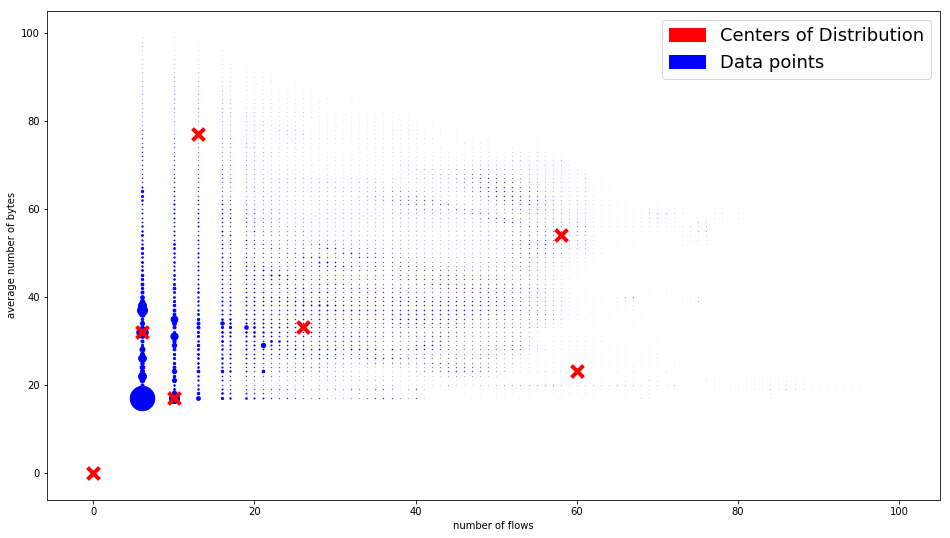

In [15]:
test = int(len(set(groupped_data['source computer'].values)))

# random initialization
onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, test, n_clusters=8, verbose=1, update_power=0.5)

plot_points(groupped_data.values[:, :2], onlineEM)

In [16]:
onlineEM.fit(groupped_data.values[:,[0,1,3]])

Running for data till position 2268 from total 39191040
Running for data till position 4536 from total 39191040


D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:209: RuntimeWarning: invalid value encountered in true_divide
  previous)


Running for data till position 6804 from total 39191040
Running for data till position 9072 from total 39191040
Running for data till position 11340 from total 39191040
Running for data till position 13608 from total 39191040
Running for data till position 15876 from total 39191040
Running for data till position 18144 from total 39191040
Running for data till position 20412 from total 39191040
Running for data till position 22680 from total 39191040
Running for data till position 24948 from total 39191040
Running for data till position 27216 from total 39191040
Running for data till position 29484 from total 39191040
Running for data till position 31752 from total 39191040
Running for data till position 34020 from total 39191040
Running for data till position 36288 from total 39191040
Running for data till position 38556 from total 39191040
Running for data till position 40824 from total 39191040
Running for data till position 43092 from total 39191040
Running for data till position 45

Running for data till position 331128 from total 39191040
Running for data till position 333396 from total 39191040
Running for data till position 335664 from total 39191040
Running for data till position 337932 from total 39191040
Running for data till position 340200 from total 39191040
Running for data till position 342468 from total 39191040
Running for data till position 344736 from total 39191040
Running for data till position 347004 from total 39191040
Running for data till position 349272 from total 39191040
Running for data till position 351540 from total 39191040
Running for data till position 353808 from total 39191040
Running for data till position 356076 from total 39191040
Running for data till position 358344 from total 39191040
Running for data till position 360612 from total 39191040
Running for data till position 362880 from total 39191040
Running for data till position 365148 from total 39191040
Running for data till position 367416 from total 39191040
Running for da

Running for data till position 653184 from total 39191040
Running for data till position 655452 from total 39191040
Running for data till position 657720 from total 39191040
Running for data till position 659988 from total 39191040
Running for data till position 662256 from total 39191040
Running for data till position 664524 from total 39191040
Running for data till position 666792 from total 39191040
Running for data till position 669060 from total 39191040
Running for data till position 671328 from total 39191040
Running for data till position 673596 from total 39191040
Running for data till position 675864 from total 39191040
Running for data till position 678132 from total 39191040
Running for data till position 680400 from total 39191040
Running for data till position 682668 from total 39191040
Running for data till position 684936 from total 39191040
Running for data till position 687204 from total 39191040
Running for data till position 689472 from total 39191040
Running for da

Running for data till position 975240 from total 39191040
Running for data till position 977508 from total 39191040
Running for data till position 979776 from total 39191040
Running for data till position 982044 from total 39191040
Running for data till position 984312 from total 39191040
Running for data till position 986580 from total 39191040
Running for data till position 988848 from total 39191040
Running for data till position 991116 from total 39191040
Running for data till position 993384 from total 39191040
Running for data till position 995652 from total 39191040
Running for data till position 997920 from total 39191040
Running for data till position 1000188 from total 39191040
Running for data till position 1002456 from total 39191040
Running for data till position 1004724 from total 39191040
Running for data till position 1006992 from total 39191040
Running for data till position 1009260 from total 39191040
Running for data till position 1011528 from total 39191040
Running 

Running for data till position 1292760 from total 39191040
Running for data till position 1295028 from total 39191040
Running for data till position 1297296 from total 39191040
Running for data till position 1299564 from total 39191040
Running for data till position 1301832 from total 39191040
Running for data till position 1304100 from total 39191040
Running for data till position 1306368 from total 39191040
Running for data till position 1308636 from total 39191040
Running for data till position 1310904 from total 39191040
Running for data till position 1313172 from total 39191040
Running for data till position 1315440 from total 39191040
Running for data till position 1317708 from total 39191040
Running for data till position 1319976 from total 39191040
Running for data till position 1322244 from total 39191040
Running for data till position 1324512 from total 39191040
Running for data till position 1326780 from total 39191040
Running for data till position 1329048 from total 391910

Running for data till position 1608012 from total 39191040
Running for data till position 1610280 from total 39191040
Running for data till position 1612548 from total 39191040
Running for data till position 1614816 from total 39191040
Running for data till position 1617084 from total 39191040
Running for data till position 1619352 from total 39191040
Running for data till position 1621620 from total 39191040
Running for data till position 1623888 from total 39191040
Running for data till position 1626156 from total 39191040
Running for data till position 1628424 from total 39191040
Running for data till position 1630692 from total 39191040
Running for data till position 1632960 from total 39191040
Running for data till position 1635228 from total 39191040
Running for data till position 1637496 from total 39191040
Running for data till position 1639764 from total 39191040
Running for data till position 1642032 from total 39191040
Running for data till position 1644300 from total 391910

Running for data till position 1923264 from total 39191040
Running for data till position 1925532 from total 39191040
Running for data till position 1927800 from total 39191040
Running for data till position 1930068 from total 39191040
Running for data till position 1932336 from total 39191040
Running for data till position 1934604 from total 39191040
Running for data till position 1936872 from total 39191040
Running for data till position 1939140 from total 39191040
Running for data till position 1941408 from total 39191040
Running for data till position 1943676 from total 39191040
Running for data till position 1945944 from total 39191040
Running for data till position 1948212 from total 39191040
Running for data till position 1950480 from total 39191040
Running for data till position 1952748 from total 39191040
Running for data till position 1955016 from total 39191040
Running for data till position 1957284 from total 39191040
Running for data till position 1959552 from total 391910

Running for data till position 2238516 from total 39191040
Running for data till position 2240784 from total 39191040
Running for data till position 2243052 from total 39191040
Running for data till position 2245320 from total 39191040
Running for data till position 2247588 from total 39191040
Running for data till position 2249856 from total 39191040
Running for data till position 2252124 from total 39191040
Running for data till position 2254392 from total 39191040
Running for data till position 2256660 from total 39191040
Running for data till position 2258928 from total 39191040
Running for data till position 2261196 from total 39191040
Running for data till position 2263464 from total 39191040
Running for data till position 2265732 from total 39191040
Running for data till position 2268000 from total 39191040
Running for data till position 2270268 from total 39191040
Running for data till position 2272536 from total 39191040
Running for data till position 2274804 from total 391910

Running for data till position 2553768 from total 39191040
Running for data till position 2556036 from total 39191040
Running for data till position 2558304 from total 39191040
Running for data till position 2560572 from total 39191040
Running for data till position 2562840 from total 39191040
Running for data till position 2565108 from total 39191040
Running for data till position 2567376 from total 39191040
Running for data till position 2569644 from total 39191040
Running for data till position 2571912 from total 39191040
Running for data till position 2574180 from total 39191040
Running for data till position 2576448 from total 39191040
Running for data till position 2578716 from total 39191040
Running for data till position 2580984 from total 39191040
Running for data till position 2583252 from total 39191040
Running for data till position 2585520 from total 39191040
Running for data till position 2587788 from total 39191040
Running for data till position 2590056 from total 391910

Running for data till position 2869020 from total 39191040
Running for data till position 2871288 from total 39191040
Running for data till position 2873556 from total 39191040
Running for data till position 2875824 from total 39191040
Running for data till position 2878092 from total 39191040
Running for data till position 2880360 from total 39191040
Running for data till position 2882628 from total 39191040
Running for data till position 2884896 from total 39191040
Running for data till position 2887164 from total 39191040
Running for data till position 2889432 from total 39191040
Running for data till position 2891700 from total 39191040
Running for data till position 2893968 from total 39191040
Running for data till position 2896236 from total 39191040
Running for data till position 2898504 from total 39191040
Running for data till position 2900772 from total 39191040
Running for data till position 2903040 from total 39191040
Running for data till position 2905308 from total 391910

Running for data till position 3184272 from total 39191040
Running for data till position 3186540 from total 39191040
Running for data till position 3188808 from total 39191040
Running for data till position 3191076 from total 39191040
Running for data till position 3193344 from total 39191040
Running for data till position 3195612 from total 39191040
Running for data till position 3197880 from total 39191040
Running for data till position 3200148 from total 39191040
Running for data till position 3202416 from total 39191040
Running for data till position 3204684 from total 39191040
Running for data till position 3206952 from total 39191040
Running for data till position 3209220 from total 39191040
Running for data till position 3211488 from total 39191040
Running for data till position 3213756 from total 39191040
Running for data till position 3216024 from total 39191040
Running for data till position 3218292 from total 39191040
Running for data till position 3220560 from total 391910

Running for data till position 3499524 from total 39191040
Running for data till position 3501792 from total 39191040
Running for data till position 3504060 from total 39191040
Running for data till position 3506328 from total 39191040
Running for data till position 3508596 from total 39191040
Running for data till position 3510864 from total 39191040
Running for data till position 3513132 from total 39191040
Running for data till position 3515400 from total 39191040
Running for data till position 3517668 from total 39191040
Running for data till position 3519936 from total 39191040
Running for data till position 3522204 from total 39191040
Running for data till position 3524472 from total 39191040
Running for data till position 3526740 from total 39191040
Running for data till position 3529008 from total 39191040
Running for data till position 3531276 from total 39191040
Running for data till position 3533544 from total 39191040
Running for data till position 3535812 from total 391910

Running for data till position 3814776 from total 39191040
Running for data till position 3817044 from total 39191040
Running for data till position 3819312 from total 39191040
Running for data till position 3821580 from total 39191040
Running for data till position 3823848 from total 39191040
Running for data till position 3826116 from total 39191040
Running for data till position 3828384 from total 39191040
Running for data till position 3830652 from total 39191040
Running for data till position 3832920 from total 39191040
Running for data till position 3835188 from total 39191040
Running for data till position 3837456 from total 39191040
Running for data till position 3839724 from total 39191040
Running for data till position 3841992 from total 39191040
Running for data till position 3844260 from total 39191040
Running for data till position 3846528 from total 39191040
Running for data till position 3848796 from total 39191040
Running for data till position 3851064 from total 391910

Running for data till position 4130028 from total 39191040
Running for data till position 4132296 from total 39191040
Running for data till position 4134564 from total 39191040
Running for data till position 4136832 from total 39191040
Running for data till position 4139100 from total 39191040
Running for data till position 4141368 from total 39191040
Running for data till position 4143636 from total 39191040
Running for data till position 4145904 from total 39191040
Running for data till position 4148172 from total 39191040
Running for data till position 4150440 from total 39191040
Running for data till position 4152708 from total 39191040
Running for data till position 4154976 from total 39191040
Running for data till position 4157244 from total 39191040
Running for data till position 4159512 from total 39191040
Running for data till position 4161780 from total 39191040
Running for data till position 4164048 from total 39191040
Running for data till position 4166316 from total 391910

Running for data till position 4445280 from total 39191040
Running for data till position 4447548 from total 39191040
Running for data till position 4449816 from total 39191040
Running for data till position 4452084 from total 39191040
Running for data till position 4454352 from total 39191040
Running for data till position 4456620 from total 39191040
Running for data till position 4458888 from total 39191040
Running for data till position 4461156 from total 39191040
Running for data till position 4463424 from total 39191040
Running for data till position 4465692 from total 39191040
Running for data till position 4467960 from total 39191040
Running for data till position 4470228 from total 39191040
Running for data till position 4472496 from total 39191040
Running for data till position 4474764 from total 39191040
Running for data till position 4477032 from total 39191040
Running for data till position 4479300 from total 39191040
Running for data till position 4481568 from total 391910

Running for data till position 4760532 from total 39191040
Running for data till position 4762800 from total 39191040
Running for data till position 4765068 from total 39191040
Running for data till position 4767336 from total 39191040
Running for data till position 4769604 from total 39191040
Running for data till position 4771872 from total 39191040
Running for data till position 4774140 from total 39191040
Running for data till position 4776408 from total 39191040
Running for data till position 4778676 from total 39191040
Running for data till position 4780944 from total 39191040
Running for data till position 4783212 from total 39191040
Running for data till position 4785480 from total 39191040
Running for data till position 4787748 from total 39191040
Running for data till position 4790016 from total 39191040
Running for data till position 4792284 from total 39191040
Running for data till position 4794552 from total 39191040
Running for data till position 4796820 from total 391910

Running for data till position 5075784 from total 39191040
Running for data till position 5078052 from total 39191040
Running for data till position 5080320 from total 39191040
Running for data till position 5082588 from total 39191040
Running for data till position 5084856 from total 39191040
Running for data till position 5087124 from total 39191040
Running for data till position 5089392 from total 39191040
Running for data till position 5091660 from total 39191040
Running for data till position 5093928 from total 39191040
Running for data till position 5096196 from total 39191040
Running for data till position 5098464 from total 39191040
Running for data till position 5100732 from total 39191040
Running for data till position 5103000 from total 39191040
Running for data till position 5105268 from total 39191040
Running for data till position 5107536 from total 39191040
Running for data till position 5109804 from total 39191040
Running for data till position 5112072 from total 391910

Running for data till position 5391036 from total 39191040
Running for data till position 5393304 from total 39191040
Running for data till position 5395572 from total 39191040
Running for data till position 5397840 from total 39191040
Running for data till position 5400108 from total 39191040
Running for data till position 5402376 from total 39191040
Running for data till position 5404644 from total 39191040
Running for data till position 5406912 from total 39191040
Running for data till position 5409180 from total 39191040
Running for data till position 5411448 from total 39191040
Running for data till position 5413716 from total 39191040
Running for data till position 5415984 from total 39191040
Running for data till position 5418252 from total 39191040
Running for data till position 5420520 from total 39191040
Running for data till position 5422788 from total 39191040
Running for data till position 5425056 from total 39191040
Running for data till position 5427324 from total 391910

Running for data till position 5706288 from total 39191040
Running for data till position 5708556 from total 39191040
Running for data till position 5710824 from total 39191040
Running for data till position 5713092 from total 39191040
Running for data till position 5715360 from total 39191040
Running for data till position 5717628 from total 39191040
Running for data till position 5719896 from total 39191040
Running for data till position 5722164 from total 39191040
Running for data till position 5724432 from total 39191040
Running for data till position 5726700 from total 39191040
Running for data till position 5728968 from total 39191040
Running for data till position 5731236 from total 39191040
Running for data till position 5733504 from total 39191040
Running for data till position 5735772 from total 39191040
Running for data till position 5738040 from total 39191040
Running for data till position 5740308 from total 39191040
Running for data till position 5742576 from total 391910

Running for data till position 6021540 from total 39191040
Running for data till position 6023808 from total 39191040
Running for data till position 6026076 from total 39191040
Running for data till position 6028344 from total 39191040
Running for data till position 6030612 from total 39191040
Running for data till position 6032880 from total 39191040
Running for data till position 6035148 from total 39191040
Running for data till position 6037416 from total 39191040
Running for data till position 6039684 from total 39191040
Running for data till position 6041952 from total 39191040
Running for data till position 6044220 from total 39191040
Running for data till position 6046488 from total 39191040
Running for data till position 6048756 from total 39191040
Running for data till position 6051024 from total 39191040
Running for data till position 6053292 from total 39191040
Running for data till position 6055560 from total 39191040
Running for data till position 6057828 from total 391910

Running for data till position 6336792 from total 39191040
Running for data till position 6339060 from total 39191040
Running for data till position 6341328 from total 39191040
Running for data till position 6343596 from total 39191040
Running for data till position 6345864 from total 39191040
Running for data till position 6348132 from total 39191040
Running for data till position 6350400 from total 39191040
Running for data till position 6352668 from total 39191040
Running for data till position 6354936 from total 39191040
Running for data till position 6357204 from total 39191040
Running for data till position 6359472 from total 39191040
Running for data till position 6361740 from total 39191040
Running for data till position 6364008 from total 39191040
Running for data till position 6366276 from total 39191040
Running for data till position 6368544 from total 39191040
Running for data till position 6370812 from total 39191040
Running for data till position 6373080 from total 391910

Running for data till position 6652044 from total 39191040
Running for data till position 6654312 from total 39191040
Running for data till position 6656580 from total 39191040
Running for data till position 6658848 from total 39191040
Running for data till position 6661116 from total 39191040
Running for data till position 6663384 from total 39191040
Running for data till position 6665652 from total 39191040
Running for data till position 6667920 from total 39191040
Running for data till position 6670188 from total 39191040
Running for data till position 6672456 from total 39191040
Running for data till position 6674724 from total 39191040
Running for data till position 6676992 from total 39191040
Running for data till position 6679260 from total 39191040
Running for data till position 6681528 from total 39191040
Running for data till position 6683796 from total 39191040
Running for data till position 6686064 from total 39191040
Running for data till position 6688332 from total 391910

Running for data till position 6967296 from total 39191040
Running for data till position 6969564 from total 39191040
Running for data till position 6971832 from total 39191040
Running for data till position 6974100 from total 39191040
Running for data till position 6976368 from total 39191040
Running for data till position 6978636 from total 39191040
Running for data till position 6980904 from total 39191040
Running for data till position 6983172 from total 39191040
Running for data till position 6985440 from total 39191040
Running for data till position 6987708 from total 39191040
Running for data till position 6989976 from total 39191040
Running for data till position 6992244 from total 39191040
Running for data till position 6994512 from total 39191040
Running for data till position 6996780 from total 39191040
Running for data till position 6999048 from total 39191040
Running for data till position 7001316 from total 39191040
Running for data till position 7003584 from total 391910

Running for data till position 7282548 from total 39191040
Running for data till position 7284816 from total 39191040
Running for data till position 7287084 from total 39191040
Running for data till position 7289352 from total 39191040
Running for data till position 7291620 from total 39191040
Running for data till position 7293888 from total 39191040
Running for data till position 7296156 from total 39191040
Running for data till position 7298424 from total 39191040
Running for data till position 7300692 from total 39191040
Running for data till position 7302960 from total 39191040
Running for data till position 7305228 from total 39191040
Running for data till position 7307496 from total 39191040
Running for data till position 7309764 from total 39191040
Running for data till position 7312032 from total 39191040
Running for data till position 7314300 from total 39191040
Running for data till position 7316568 from total 39191040
Running for data till position 7318836 from total 391910

Running for data till position 7597800 from total 39191040
Running for data till position 7600068 from total 39191040
Running for data till position 7602336 from total 39191040
Running for data till position 7604604 from total 39191040
Running for data till position 7606872 from total 39191040
Running for data till position 7609140 from total 39191040
Running for data till position 7611408 from total 39191040
Running for data till position 7613676 from total 39191040
Running for data till position 7615944 from total 39191040
Running for data till position 7618212 from total 39191040
Running for data till position 7620480 from total 39191040
Running for data till position 7622748 from total 39191040
Running for data till position 7625016 from total 39191040
Running for data till position 7627284 from total 39191040
Running for data till position 7629552 from total 39191040
Running for data till position 7631820 from total 39191040
Running for data till position 7634088 from total 391910

Running for data till position 7913052 from total 39191040
Running for data till position 7915320 from total 39191040
Running for data till position 7917588 from total 39191040
Running for data till position 7919856 from total 39191040
Running for data till position 7922124 from total 39191040
Running for data till position 7924392 from total 39191040
Running for data till position 7926660 from total 39191040
Running for data till position 7928928 from total 39191040
Running for data till position 7931196 from total 39191040
Running for data till position 7933464 from total 39191040
Running for data till position 7935732 from total 39191040
Running for data till position 7938000 from total 39191040
Running for data till position 7940268 from total 39191040
Running for data till position 7942536 from total 39191040
Running for data till position 7944804 from total 39191040
Running for data till position 7947072 from total 39191040
Running for data till position 7949340 from total 391910

Running for data till position 8228304 from total 39191040
Running for data till position 8230572 from total 39191040
Running for data till position 8232840 from total 39191040
Running for data till position 8235108 from total 39191040
Running for data till position 8237376 from total 39191040
Running for data till position 8239644 from total 39191040
Running for data till position 8241912 from total 39191040
Running for data till position 8244180 from total 39191040
Running for data till position 8246448 from total 39191040
Running for data till position 8248716 from total 39191040
Running for data till position 8250984 from total 39191040
Running for data till position 8253252 from total 39191040
Running for data till position 8255520 from total 39191040
Running for data till position 8257788 from total 39191040
Running for data till position 8260056 from total 39191040
Running for data till position 8262324 from total 39191040
Running for data till position 8264592 from total 391910

Running for data till position 8543556 from total 39191040
Running for data till position 8545824 from total 39191040
Running for data till position 8548092 from total 39191040
Running for data till position 8550360 from total 39191040
Running for data till position 8552628 from total 39191040
Running for data till position 8554896 from total 39191040
Running for data till position 8557164 from total 39191040
Running for data till position 8559432 from total 39191040
Running for data till position 8561700 from total 39191040
Running for data till position 8563968 from total 39191040
Running for data till position 8566236 from total 39191040
Running for data till position 8568504 from total 39191040
Running for data till position 8570772 from total 39191040
Running for data till position 8573040 from total 39191040
Running for data till position 8575308 from total 39191040
Running for data till position 8577576 from total 39191040
Running for data till position 8579844 from total 391910

Running for data till position 8858808 from total 39191040
Running for data till position 8861076 from total 39191040
Running for data till position 8863344 from total 39191040
Running for data till position 8865612 from total 39191040
Running for data till position 8867880 from total 39191040
Running for data till position 8870148 from total 39191040
Running for data till position 8872416 from total 39191040
Running for data till position 8874684 from total 39191040
Running for data till position 8876952 from total 39191040
Running for data till position 8879220 from total 39191040
Running for data till position 8881488 from total 39191040
Running for data till position 8883756 from total 39191040
Running for data till position 8886024 from total 39191040
Running for data till position 8888292 from total 39191040
Running for data till position 8890560 from total 39191040
Running for data till position 8892828 from total 39191040
Running for data till position 8895096 from total 391910

Running for data till position 9174060 from total 39191040
Running for data till position 9176328 from total 39191040
Running for data till position 9178596 from total 39191040
Running for data till position 9180864 from total 39191040
Running for data till position 9183132 from total 39191040
Running for data till position 9185400 from total 39191040
Running for data till position 9187668 from total 39191040
Running for data till position 9189936 from total 39191040
Running for data till position 9192204 from total 39191040
Running for data till position 9194472 from total 39191040
Running for data till position 9196740 from total 39191040
Running for data till position 9199008 from total 39191040
Running for data till position 9201276 from total 39191040
Running for data till position 9203544 from total 39191040
Running for data till position 9205812 from total 39191040
Running for data till position 9208080 from total 39191040
Running for data till position 9210348 from total 391910

Running for data till position 9489312 from total 39191040
Running for data till position 9491580 from total 39191040
Running for data till position 9493848 from total 39191040
Running for data till position 9496116 from total 39191040
Running for data till position 9498384 from total 39191040
Running for data till position 9500652 from total 39191040
Running for data till position 9502920 from total 39191040
Running for data till position 9505188 from total 39191040
Running for data till position 9507456 from total 39191040
Running for data till position 9509724 from total 39191040
Running for data till position 9511992 from total 39191040
Running for data till position 9514260 from total 39191040
Running for data till position 9516528 from total 39191040
Running for data till position 9518796 from total 39191040
Running for data till position 9521064 from total 39191040
Running for data till position 9523332 from total 39191040
Running for data till position 9525600 from total 391910

Running for data till position 9804564 from total 39191040
Running for data till position 9806832 from total 39191040
Running for data till position 9809100 from total 39191040
Running for data till position 9811368 from total 39191040
Running for data till position 9813636 from total 39191040
Running for data till position 9815904 from total 39191040
Running for data till position 9818172 from total 39191040
Running for data till position 9820440 from total 39191040
Running for data till position 9822708 from total 39191040
Running for data till position 9824976 from total 39191040
Running for data till position 9827244 from total 39191040
Running for data till position 9829512 from total 39191040
Running for data till position 9831780 from total 39191040
Running for data till position 9834048 from total 39191040
Running for data till position 9836316 from total 39191040
Running for data till position 9838584 from total 39191040
Running for data till position 9840852 from total 391910

Running for data till position 10117548 from total 39191040
Running for data till position 10119816 from total 39191040
Running for data till position 10122084 from total 39191040
Running for data till position 10124352 from total 39191040
Running for data till position 10126620 from total 39191040
Running for data till position 10128888 from total 39191040
Running for data till position 10131156 from total 39191040
Running for data till position 10133424 from total 39191040
Running for data till position 10135692 from total 39191040
Running for data till position 10137960 from total 39191040
Running for data till position 10140228 from total 39191040
Running for data till position 10142496 from total 39191040
Running for data till position 10144764 from total 39191040
Running for data till position 10147032 from total 39191040
Running for data till position 10149300 from total 39191040
Running for data till position 10151568 from total 39191040
Running for data till position 10153836 

Running for data till position 10428264 from total 39191040
Running for data till position 10430532 from total 39191040
Running for data till position 10432800 from total 39191040
Running for data till position 10435068 from total 39191040
Running for data till position 10437336 from total 39191040
Running for data till position 10439604 from total 39191040
Running for data till position 10441872 from total 39191040
Running for data till position 10444140 from total 39191040
Running for data till position 10446408 from total 39191040
Running for data till position 10448676 from total 39191040
Running for data till position 10450944 from total 39191040
Running for data till position 10453212 from total 39191040
Running for data till position 10455480 from total 39191040
Running for data till position 10457748 from total 39191040
Running for data till position 10460016 from total 39191040
Running for data till position 10462284 from total 39191040
Running for data till position 10464552 

Running for data till position 10738980 from total 39191040
Running for data till position 10741248 from total 39191040
Running for data till position 10743516 from total 39191040
Running for data till position 10745784 from total 39191040
Running for data till position 10748052 from total 39191040
Running for data till position 10750320 from total 39191040
Running for data till position 10752588 from total 39191040
Running for data till position 10754856 from total 39191040
Running for data till position 10757124 from total 39191040
Running for data till position 10759392 from total 39191040
Running for data till position 10761660 from total 39191040
Running for data till position 10763928 from total 39191040
Running for data till position 10766196 from total 39191040
Running for data till position 10768464 from total 39191040
Running for data till position 10770732 from total 39191040
Running for data till position 10773000 from total 39191040
Running for data till position 10775268 

Running for data till position 11049696 from total 39191040
Running for data till position 11051964 from total 39191040
Running for data till position 11054232 from total 39191040
Running for data till position 11056500 from total 39191040
Running for data till position 11058768 from total 39191040
Running for data till position 11061036 from total 39191040
Running for data till position 11063304 from total 39191040
Running for data till position 11065572 from total 39191040
Running for data till position 11067840 from total 39191040
Running for data till position 11070108 from total 39191040
Running for data till position 11072376 from total 39191040
Running for data till position 11074644 from total 39191040
Running for data till position 11076912 from total 39191040
Running for data till position 11079180 from total 39191040
Running for data till position 11081448 from total 39191040
Running for data till position 11083716 from total 39191040
Running for data till position 11085984 

Running for data till position 11360412 from total 39191040
Running for data till position 11362680 from total 39191040
Running for data till position 11364948 from total 39191040
Running for data till position 11367216 from total 39191040
Running for data till position 11369484 from total 39191040
Running for data till position 11371752 from total 39191040
Running for data till position 11374020 from total 39191040
Running for data till position 11376288 from total 39191040
Running for data till position 11378556 from total 39191040
Running for data till position 11380824 from total 39191040
Running for data till position 11383092 from total 39191040
Running for data till position 11385360 from total 39191040
Running for data till position 11387628 from total 39191040
Running for data till position 11389896 from total 39191040
Running for data till position 11392164 from total 39191040
Running for data till position 11394432 from total 39191040
Running for data till position 11396700 

Running for data till position 11671128 from total 39191040
Running for data till position 11673396 from total 39191040
Running for data till position 11675664 from total 39191040
Running for data till position 11677932 from total 39191040
Running for data till position 11680200 from total 39191040
Running for data till position 11682468 from total 39191040
Running for data till position 11684736 from total 39191040
Running for data till position 11687004 from total 39191040
Running for data till position 11689272 from total 39191040
Running for data till position 11691540 from total 39191040
Running for data till position 11693808 from total 39191040
Running for data till position 11696076 from total 39191040
Running for data till position 11698344 from total 39191040
Running for data till position 11700612 from total 39191040
Running for data till position 11702880 from total 39191040
Running for data till position 11705148 from total 39191040
Running for data till position 11707416 

Running for data till position 11981844 from total 39191040
Running for data till position 11984112 from total 39191040
Running for data till position 11986380 from total 39191040
Running for data till position 11988648 from total 39191040
Running for data till position 11990916 from total 39191040
Running for data till position 11993184 from total 39191040
Running for data till position 11995452 from total 39191040
Running for data till position 11997720 from total 39191040
Running for data till position 11999988 from total 39191040
Running for data till position 12002256 from total 39191040
Running for data till position 12004524 from total 39191040
Running for data till position 12006792 from total 39191040
Running for data till position 12009060 from total 39191040
Running for data till position 12011328 from total 39191040
Running for data till position 12013596 from total 39191040
Running for data till position 12015864 from total 39191040
Running for data till position 12018132 

Running for data till position 12292560 from total 39191040
Running for data till position 12294828 from total 39191040
Running for data till position 12297096 from total 39191040
Running for data till position 12299364 from total 39191040
Running for data till position 12301632 from total 39191040
Running for data till position 12303900 from total 39191040
Running for data till position 12306168 from total 39191040
Running for data till position 12308436 from total 39191040
Running for data till position 12310704 from total 39191040
Running for data till position 12312972 from total 39191040
Running for data till position 12315240 from total 39191040
Running for data till position 12317508 from total 39191040
Running for data till position 12319776 from total 39191040
Running for data till position 12322044 from total 39191040
Running for data till position 12324312 from total 39191040
Running for data till position 12326580 from total 39191040
Running for data till position 12328848 

Running for data till position 12603276 from total 39191040
Running for data till position 12605544 from total 39191040
Running for data till position 12607812 from total 39191040
Running for data till position 12610080 from total 39191040
Running for data till position 12612348 from total 39191040
Running for data till position 12614616 from total 39191040
Running for data till position 12616884 from total 39191040
Running for data till position 12619152 from total 39191040
Running for data till position 12621420 from total 39191040
Running for data till position 12623688 from total 39191040
Running for data till position 12625956 from total 39191040
Running for data till position 12628224 from total 39191040
Running for data till position 12630492 from total 39191040
Running for data till position 12632760 from total 39191040
Running for data till position 12635028 from total 39191040
Running for data till position 12637296 from total 39191040
Running for data till position 12639564 

Running for data till position 12913992 from total 39191040
Running for data till position 12916260 from total 39191040
Running for data till position 12918528 from total 39191040
Running for data till position 12920796 from total 39191040
Running for data till position 12923064 from total 39191040
Running for data till position 12925332 from total 39191040
Running for data till position 12927600 from total 39191040
Running for data till position 12929868 from total 39191040
Running for data till position 12932136 from total 39191040
Running for data till position 12934404 from total 39191040
Running for data till position 12936672 from total 39191040
Running for data till position 12938940 from total 39191040
Running for data till position 12941208 from total 39191040
Running for data till position 12943476 from total 39191040
Running for data till position 12945744 from total 39191040
Running for data till position 12948012 from total 39191040
Running for data till position 12950280 

Running for data till position 13224708 from total 39191040
Running for data till position 13226976 from total 39191040
Running for data till position 13229244 from total 39191040
Running for data till position 13231512 from total 39191040
Running for data till position 13233780 from total 39191040
Running for data till position 13236048 from total 39191040
Running for data till position 13238316 from total 39191040
Running for data till position 13240584 from total 39191040
Running for data till position 13242852 from total 39191040
Running for data till position 13245120 from total 39191040
Running for data till position 13247388 from total 39191040
Running for data till position 13249656 from total 39191040
Running for data till position 13251924 from total 39191040
Running for data till position 13254192 from total 39191040
Running for data till position 13256460 from total 39191040
Running for data till position 13258728 from total 39191040
Running for data till position 13260996 

Running for data till position 13535424 from total 39191040
Running for data till position 13537692 from total 39191040
Running for data till position 13539960 from total 39191040
Running for data till position 13542228 from total 39191040
Running for data till position 13544496 from total 39191040
Running for data till position 13546764 from total 39191040
Running for data till position 13549032 from total 39191040
Running for data till position 13551300 from total 39191040
Running for data till position 13553568 from total 39191040
Running for data till position 13555836 from total 39191040
Running for data till position 13558104 from total 39191040
Running for data till position 13560372 from total 39191040
Running for data till position 13562640 from total 39191040
Running for data till position 13564908 from total 39191040
Running for data till position 13567176 from total 39191040
Running for data till position 13569444 from total 39191040
Running for data till position 13571712 

Running for data till position 13846140 from total 39191040
Running for data till position 13848408 from total 39191040
Running for data till position 13850676 from total 39191040
Running for data till position 13852944 from total 39191040
Running for data till position 13855212 from total 39191040
Running for data till position 13857480 from total 39191040
Running for data till position 13859748 from total 39191040
Running for data till position 13862016 from total 39191040
Running for data till position 13864284 from total 39191040
Running for data till position 13866552 from total 39191040
Running for data till position 13868820 from total 39191040
Running for data till position 13871088 from total 39191040
Running for data till position 13873356 from total 39191040
Running for data till position 13875624 from total 39191040
Running for data till position 13877892 from total 39191040
Running for data till position 13880160 from total 39191040
Running for data till position 13882428 

Running for data till position 14156856 from total 39191040
Running for data till position 14159124 from total 39191040
Running for data till position 14161392 from total 39191040
Running for data till position 14163660 from total 39191040
Running for data till position 14165928 from total 39191040
Running for data till position 14168196 from total 39191040
Running for data till position 14170464 from total 39191040
Running for data till position 14172732 from total 39191040
Running for data till position 14175000 from total 39191040
Running for data till position 14177268 from total 39191040
Running for data till position 14179536 from total 39191040
Running for data till position 14181804 from total 39191040
Running for data till position 14184072 from total 39191040
Running for data till position 14186340 from total 39191040
Running for data till position 14188608 from total 39191040
Running for data till position 14190876 from total 39191040
Running for data till position 14193144 

Running for data till position 14467572 from total 39191040
Running for data till position 14469840 from total 39191040
Running for data till position 14472108 from total 39191040
Running for data till position 14474376 from total 39191040
Running for data till position 14476644 from total 39191040
Running for data till position 14478912 from total 39191040
Running for data till position 14481180 from total 39191040
Running for data till position 14483448 from total 39191040
Running for data till position 14485716 from total 39191040
Running for data till position 14487984 from total 39191040
Running for data till position 14490252 from total 39191040
Running for data till position 14492520 from total 39191040
Running for data till position 14494788 from total 39191040
Running for data till position 14497056 from total 39191040
Running for data till position 14499324 from total 39191040
Running for data till position 14501592 from total 39191040
Running for data till position 14503860 

Running for data till position 14778288 from total 39191040
Running for data till position 14780556 from total 39191040
Running for data till position 14782824 from total 39191040
Running for data till position 14785092 from total 39191040
Running for data till position 14787360 from total 39191040
Running for data till position 14789628 from total 39191040
Running for data till position 14791896 from total 39191040
Running for data till position 14794164 from total 39191040
Running for data till position 14796432 from total 39191040
Running for data till position 14798700 from total 39191040
Running for data till position 14800968 from total 39191040
Running for data till position 14803236 from total 39191040
Running for data till position 14805504 from total 39191040
Running for data till position 14807772 from total 39191040
Running for data till position 14810040 from total 39191040
Running for data till position 14812308 from total 39191040
Running for data till position 14814576 

Running for data till position 15089004 from total 39191040
Running for data till position 15091272 from total 39191040
Running for data till position 15093540 from total 39191040
Running for data till position 15095808 from total 39191040
Running for data till position 15098076 from total 39191040
Running for data till position 15100344 from total 39191040
Running for data till position 15102612 from total 39191040
Running for data till position 15104880 from total 39191040
Running for data till position 15107148 from total 39191040
Running for data till position 15109416 from total 39191040
Running for data till position 15111684 from total 39191040
Running for data till position 15113952 from total 39191040
Running for data till position 15116220 from total 39191040
Running for data till position 15118488 from total 39191040
Running for data till position 15120756 from total 39191040
Running for data till position 15123024 from total 39191040
Running for data till position 15125292 

Running for data till position 15399720 from total 39191040
Running for data till position 15401988 from total 39191040
Running for data till position 15404256 from total 39191040
Running for data till position 15406524 from total 39191040
Running for data till position 15408792 from total 39191040
Running for data till position 15411060 from total 39191040
Running for data till position 15413328 from total 39191040
Running for data till position 15415596 from total 39191040
Running for data till position 15417864 from total 39191040
Running for data till position 15420132 from total 39191040
Running for data till position 15422400 from total 39191040
Running for data till position 15424668 from total 39191040
Running for data till position 15426936 from total 39191040
Running for data till position 15429204 from total 39191040
Running for data till position 15431472 from total 39191040
Running for data till position 15433740 from total 39191040
Running for data till position 15436008 

Running for data till position 15710436 from total 39191040
Running for data till position 15712704 from total 39191040
Running for data till position 15714972 from total 39191040
Running for data till position 15717240 from total 39191040
Running for data till position 15719508 from total 39191040
Running for data till position 15721776 from total 39191040
Running for data till position 15724044 from total 39191040
Running for data till position 15726312 from total 39191040
Running for data till position 15728580 from total 39191040
Running for data till position 15730848 from total 39191040
Running for data till position 15733116 from total 39191040
Running for data till position 15735384 from total 39191040
Running for data till position 15737652 from total 39191040
Running for data till position 15739920 from total 39191040
Running for data till position 15742188 from total 39191040
Running for data till position 15744456 from total 39191040
Running for data till position 15746724 

Running for data till position 16021152 from total 39191040
Running for data till position 16023420 from total 39191040
Running for data till position 16025688 from total 39191040
Running for data till position 16027956 from total 39191040
Running for data till position 16030224 from total 39191040
Running for data till position 16032492 from total 39191040
Running for data till position 16034760 from total 39191040
Running for data till position 16037028 from total 39191040
Running for data till position 16039296 from total 39191040
Running for data till position 16041564 from total 39191040
Running for data till position 16043832 from total 39191040
Running for data till position 16046100 from total 39191040
Running for data till position 16048368 from total 39191040
Running for data till position 16050636 from total 39191040
Running for data till position 16052904 from total 39191040
Running for data till position 16055172 from total 39191040
Running for data till position 16057440 

Running for data till position 16331868 from total 39191040
Running for data till position 16334136 from total 39191040
Running for data till position 16336404 from total 39191040
Running for data till position 16338672 from total 39191040
Running for data till position 16340940 from total 39191040
Running for data till position 16343208 from total 39191040
Running for data till position 16345476 from total 39191040
Running for data till position 16347744 from total 39191040
Running for data till position 16350012 from total 39191040
Running for data till position 16352280 from total 39191040
Running for data till position 16354548 from total 39191040
Running for data till position 16356816 from total 39191040
Running for data till position 16359084 from total 39191040
Running for data till position 16361352 from total 39191040
Running for data till position 16363620 from total 39191040
Running for data till position 16365888 from total 39191040
Running for data till position 16368156 

Running for data till position 16642584 from total 39191040
Running for data till position 16644852 from total 39191040
Running for data till position 16647120 from total 39191040
Running for data till position 16649388 from total 39191040
Running for data till position 16651656 from total 39191040
Running for data till position 16653924 from total 39191040
Running for data till position 16656192 from total 39191040
Running for data till position 16658460 from total 39191040
Running for data till position 16660728 from total 39191040
Running for data till position 16662996 from total 39191040
Running for data till position 16665264 from total 39191040
Running for data till position 16667532 from total 39191040
Running for data till position 16669800 from total 39191040
Running for data till position 16672068 from total 39191040
Running for data till position 16674336 from total 39191040
Running for data till position 16676604 from total 39191040
Running for data till position 16678872 

Running for data till position 16953300 from total 39191040
Running for data till position 16955568 from total 39191040
Running for data till position 16957836 from total 39191040
Running for data till position 16960104 from total 39191040
Running for data till position 16962372 from total 39191040
Running for data till position 16964640 from total 39191040
Running for data till position 16966908 from total 39191040
Running for data till position 16969176 from total 39191040
Running for data till position 16971444 from total 39191040
Running for data till position 16973712 from total 39191040
Running for data till position 16975980 from total 39191040
Running for data till position 16978248 from total 39191040
Running for data till position 16980516 from total 39191040
Running for data till position 16982784 from total 39191040
Running for data till position 16985052 from total 39191040
Running for data till position 16987320 from total 39191040
Running for data till position 16989588 

Running for data till position 17264016 from total 39191040
Running for data till position 17266284 from total 39191040
Running for data till position 17268552 from total 39191040
Running for data till position 17270820 from total 39191040
Running for data till position 17273088 from total 39191040
Running for data till position 17275356 from total 39191040
Running for data till position 17277624 from total 39191040
Running for data till position 17279892 from total 39191040
Running for data till position 17282160 from total 39191040
Running for data till position 17284428 from total 39191040
Running for data till position 17286696 from total 39191040
Running for data till position 17288964 from total 39191040
Running for data till position 17291232 from total 39191040
Running for data till position 17293500 from total 39191040
Running for data till position 17295768 from total 39191040
Running for data till position 17298036 from total 39191040
Running for data till position 17300304 

Running for data till position 17574732 from total 39191040
Running for data till position 17577000 from total 39191040
Running for data till position 17579268 from total 39191040
Running for data till position 17581536 from total 39191040
Running for data till position 17583804 from total 39191040
Running for data till position 17586072 from total 39191040
Running for data till position 17588340 from total 39191040
Running for data till position 17590608 from total 39191040
Running for data till position 17592876 from total 39191040
Running for data till position 17595144 from total 39191040
Running for data till position 17597412 from total 39191040
Running for data till position 17599680 from total 39191040
Running for data till position 17601948 from total 39191040
Running for data till position 17604216 from total 39191040
Running for data till position 17606484 from total 39191040
Running for data till position 17608752 from total 39191040
Running for data till position 17611020 

Running for data till position 17885448 from total 39191040
Running for data till position 17887716 from total 39191040
Running for data till position 17889984 from total 39191040
Running for data till position 17892252 from total 39191040
Running for data till position 17894520 from total 39191040
Running for data till position 17896788 from total 39191040
Running for data till position 17899056 from total 39191040
Running for data till position 17901324 from total 39191040
Running for data till position 17903592 from total 39191040
Running for data till position 17905860 from total 39191040
Running for data till position 17908128 from total 39191040
Running for data till position 17910396 from total 39191040
Running for data till position 17912664 from total 39191040
Running for data till position 17914932 from total 39191040
Running for data till position 17917200 from total 39191040
Running for data till position 17919468 from total 39191040
Running for data till position 17921736 

Running for data till position 18196164 from total 39191040
Running for data till position 18198432 from total 39191040
Running for data till position 18200700 from total 39191040
Running for data till position 18202968 from total 39191040
Running for data till position 18205236 from total 39191040
Running for data till position 18207504 from total 39191040
Running for data till position 18209772 from total 39191040
Running for data till position 18212040 from total 39191040
Running for data till position 18214308 from total 39191040
Running for data till position 18216576 from total 39191040
Running for data till position 18218844 from total 39191040
Running for data till position 18221112 from total 39191040
Running for data till position 18223380 from total 39191040
Running for data till position 18225648 from total 39191040
Running for data till position 18227916 from total 39191040
Running for data till position 18230184 from total 39191040
Running for data till position 18232452 

Running for data till position 18506880 from total 39191040
Running for data till position 18509148 from total 39191040
Running for data till position 18511416 from total 39191040
Running for data till position 18513684 from total 39191040
Running for data till position 18515952 from total 39191040
Running for data till position 18518220 from total 39191040
Running for data till position 18520488 from total 39191040
Running for data till position 18522756 from total 39191040
Running for data till position 18525024 from total 39191040
Running for data till position 18527292 from total 39191040
Running for data till position 18529560 from total 39191040
Running for data till position 18531828 from total 39191040
Running for data till position 18534096 from total 39191040
Running for data till position 18536364 from total 39191040
Running for data till position 18538632 from total 39191040
Running for data till position 18540900 from total 39191040
Running for data till position 18543168 

Running for data till position 18817596 from total 39191040
Running for data till position 18819864 from total 39191040
Running for data till position 18822132 from total 39191040
Running for data till position 18824400 from total 39191040
Running for data till position 18826668 from total 39191040
Running for data till position 18828936 from total 39191040
Running for data till position 18831204 from total 39191040
Running for data till position 18833472 from total 39191040
Running for data till position 18835740 from total 39191040
Running for data till position 18838008 from total 39191040
Running for data till position 18840276 from total 39191040
Running for data till position 18842544 from total 39191040
Running for data till position 18844812 from total 39191040
Running for data till position 18847080 from total 39191040
Running for data till position 18849348 from total 39191040
Running for data till position 18851616 from total 39191040
Running for data till position 18853884 

Running for data till position 19128312 from total 39191040
Running for data till position 19130580 from total 39191040
Running for data till position 19132848 from total 39191040
Running for data till position 19135116 from total 39191040
Running for data till position 19137384 from total 39191040
Running for data till position 19139652 from total 39191040
Running for data till position 19141920 from total 39191040
Running for data till position 19144188 from total 39191040
Running for data till position 19146456 from total 39191040
Running for data till position 19148724 from total 39191040
Running for data till position 19150992 from total 39191040
Running for data till position 19153260 from total 39191040
Running for data till position 19155528 from total 39191040
Running for data till position 19157796 from total 39191040
Running for data till position 19160064 from total 39191040
Running for data till position 19162332 from total 39191040
Running for data till position 19164600 

Running for data till position 19439028 from total 39191040
Running for data till position 19441296 from total 39191040
Running for data till position 19443564 from total 39191040
Running for data till position 19445832 from total 39191040
Running for data till position 19448100 from total 39191040
Running for data till position 19450368 from total 39191040
Running for data till position 19452636 from total 39191040
Running for data till position 19454904 from total 39191040
Running for data till position 19457172 from total 39191040
Running for data till position 19459440 from total 39191040
Running for data till position 19461708 from total 39191040
Running for data till position 19463976 from total 39191040
Running for data till position 19466244 from total 39191040
Running for data till position 19468512 from total 39191040
Running for data till position 19470780 from total 39191040
Running for data till position 19473048 from total 39191040
Running for data till position 19475316 

Running for data till position 19749744 from total 39191040
Running for data till position 19752012 from total 39191040
Running for data till position 19754280 from total 39191040
Running for data till position 19756548 from total 39191040
Running for data till position 19758816 from total 39191040
Running for data till position 19761084 from total 39191040
Running for data till position 19763352 from total 39191040
Running for data till position 19765620 from total 39191040
Running for data till position 19767888 from total 39191040
Running for data till position 19770156 from total 39191040
Running for data till position 19772424 from total 39191040
Running for data till position 19774692 from total 39191040
Running for data till position 19776960 from total 39191040
Running for data till position 19779228 from total 39191040
Running for data till position 19781496 from total 39191040
Running for data till position 19783764 from total 39191040
Running for data till position 19786032 

Running for data till position 20060460 from total 39191040
Running for data till position 20062728 from total 39191040
Running for data till position 20064996 from total 39191040
Running for data till position 20067264 from total 39191040
Running for data till position 20069532 from total 39191040
Running for data till position 20071800 from total 39191040
Running for data till position 20074068 from total 39191040
Running for data till position 20076336 from total 39191040
Running for data till position 20078604 from total 39191040
Running for data till position 20080872 from total 39191040
Running for data till position 20083140 from total 39191040
Running for data till position 20085408 from total 39191040
Running for data till position 20087676 from total 39191040
Running for data till position 20089944 from total 39191040
Running for data till position 20092212 from total 39191040
Running for data till position 20094480 from total 39191040
Running for data till position 20096748 

Running for data till position 20371176 from total 39191040
Running for data till position 20373444 from total 39191040
Running for data till position 20375712 from total 39191040
Running for data till position 20377980 from total 39191040
Running for data till position 20380248 from total 39191040
Running for data till position 20382516 from total 39191040
Running for data till position 20384784 from total 39191040
Running for data till position 20387052 from total 39191040
Running for data till position 20389320 from total 39191040
Running for data till position 20391588 from total 39191040
Running for data till position 20393856 from total 39191040
Running for data till position 20396124 from total 39191040
Running for data till position 20398392 from total 39191040
Running for data till position 20400660 from total 39191040
Running for data till position 20402928 from total 39191040
Running for data till position 20405196 from total 39191040
Running for data till position 20407464 

Running for data till position 20681892 from total 39191040
Running for data till position 20684160 from total 39191040
Running for data till position 20686428 from total 39191040
Running for data till position 20688696 from total 39191040
Running for data till position 20690964 from total 39191040
Running for data till position 20693232 from total 39191040
Running for data till position 20695500 from total 39191040
Running for data till position 20697768 from total 39191040
Running for data till position 20700036 from total 39191040
Running for data till position 20702304 from total 39191040
Running for data till position 20704572 from total 39191040
Running for data till position 20706840 from total 39191040
Running for data till position 20709108 from total 39191040
Running for data till position 20711376 from total 39191040
Running for data till position 20713644 from total 39191040
Running for data till position 20715912 from total 39191040
Running for data till position 20718180 

Running for data till position 20992608 from total 39191040
Running for data till position 20994876 from total 39191040
Running for data till position 20997144 from total 39191040
Running for data till position 20999412 from total 39191040
Running for data till position 21001680 from total 39191040
Running for data till position 21003948 from total 39191040
Running for data till position 21006216 from total 39191040
Running for data till position 21008484 from total 39191040
Running for data till position 21010752 from total 39191040
Running for data till position 21013020 from total 39191040
Running for data till position 21015288 from total 39191040
Running for data till position 21017556 from total 39191040
Running for data till position 21019824 from total 39191040
Running for data till position 21022092 from total 39191040
Running for data till position 21024360 from total 39191040
Running for data till position 21026628 from total 39191040
Running for data till position 21028896 

Running for data till position 21303324 from total 39191040
Running for data till position 21305592 from total 39191040
Running for data till position 21307860 from total 39191040
Running for data till position 21310128 from total 39191040
Running for data till position 21312396 from total 39191040
Running for data till position 21314664 from total 39191040
Running for data till position 21316932 from total 39191040
Running for data till position 21319200 from total 39191040
Running for data till position 21321468 from total 39191040
Running for data till position 21323736 from total 39191040
Running for data till position 21326004 from total 39191040
Running for data till position 21328272 from total 39191040
Running for data till position 21330540 from total 39191040
Running for data till position 21332808 from total 39191040
Running for data till position 21335076 from total 39191040
Running for data till position 21337344 from total 39191040
Running for data till position 21339612 

Running for data till position 21614040 from total 39191040
Running for data till position 21616308 from total 39191040
Running for data till position 21618576 from total 39191040
Running for data till position 21620844 from total 39191040
Running for data till position 21623112 from total 39191040
Running for data till position 21625380 from total 39191040
Running for data till position 21627648 from total 39191040
Running for data till position 21629916 from total 39191040
Running for data till position 21632184 from total 39191040
Running for data till position 21634452 from total 39191040
Running for data till position 21636720 from total 39191040
Running for data till position 21638988 from total 39191040
Running for data till position 21641256 from total 39191040
Running for data till position 21643524 from total 39191040
Running for data till position 21645792 from total 39191040
Running for data till position 21648060 from total 39191040
Running for data till position 21650328 

Running for data till position 21924756 from total 39191040
Running for data till position 21927024 from total 39191040
Running for data till position 21929292 from total 39191040
Running for data till position 21931560 from total 39191040
Running for data till position 21933828 from total 39191040
Running for data till position 21936096 from total 39191040
Running for data till position 21938364 from total 39191040
Running for data till position 21940632 from total 39191040
Running for data till position 21942900 from total 39191040
Running for data till position 21945168 from total 39191040
Running for data till position 21947436 from total 39191040
Running for data till position 21949704 from total 39191040
Running for data till position 21951972 from total 39191040
Running for data till position 21954240 from total 39191040
Running for data till position 21956508 from total 39191040
Running for data till position 21958776 from total 39191040
Running for data till position 21961044 

Running for data till position 22235472 from total 39191040
Running for data till position 22237740 from total 39191040
Running for data till position 22240008 from total 39191040
Running for data till position 22242276 from total 39191040
Running for data till position 22244544 from total 39191040
Running for data till position 22246812 from total 39191040
Running for data till position 22249080 from total 39191040
Running for data till position 22251348 from total 39191040
Running for data till position 22253616 from total 39191040
Running for data till position 22255884 from total 39191040
Running for data till position 22258152 from total 39191040
Running for data till position 22260420 from total 39191040
Running for data till position 22262688 from total 39191040
Running for data till position 22264956 from total 39191040
Running for data till position 22267224 from total 39191040
Running for data till position 22269492 from total 39191040
Running for data till position 22271760 

Running for data till position 22546188 from total 39191040
Running for data till position 22548456 from total 39191040
Running for data till position 22550724 from total 39191040
Running for data till position 22552992 from total 39191040
Running for data till position 22555260 from total 39191040
Running for data till position 22557528 from total 39191040
Running for data till position 22559796 from total 39191040
Running for data till position 22562064 from total 39191040
Running for data till position 22564332 from total 39191040
Running for data till position 22566600 from total 39191040
Running for data till position 22568868 from total 39191040
Running for data till position 22571136 from total 39191040
Running for data till position 22573404 from total 39191040
Running for data till position 22575672 from total 39191040
Running for data till position 22577940 from total 39191040
Running for data till position 22580208 from total 39191040
Running for data till position 22582476 

Running for data till position 22856904 from total 39191040
Running for data till position 22859172 from total 39191040
Running for data till position 22861440 from total 39191040
Running for data till position 22863708 from total 39191040
Running for data till position 22865976 from total 39191040
Running for data till position 22868244 from total 39191040
Running for data till position 22870512 from total 39191040
Running for data till position 22872780 from total 39191040
Running for data till position 22875048 from total 39191040
Running for data till position 22877316 from total 39191040
Running for data till position 22879584 from total 39191040
Running for data till position 22881852 from total 39191040
Running for data till position 22884120 from total 39191040
Running for data till position 22886388 from total 39191040
Running for data till position 22888656 from total 39191040
Running for data till position 22890924 from total 39191040
Running for data till position 22893192 

Running for data till position 23167620 from total 39191040
Running for data till position 23169888 from total 39191040
Running for data till position 23172156 from total 39191040
Running for data till position 23174424 from total 39191040
Running for data till position 23176692 from total 39191040
Running for data till position 23178960 from total 39191040
Running for data till position 23181228 from total 39191040
Running for data till position 23183496 from total 39191040
Running for data till position 23185764 from total 39191040
Running for data till position 23188032 from total 39191040
Running for data till position 23190300 from total 39191040
Running for data till position 23192568 from total 39191040
Running for data till position 23194836 from total 39191040
Running for data till position 23197104 from total 39191040
Running for data till position 23199372 from total 39191040
Running for data till position 23201640 from total 39191040
Running for data till position 23203908 

Running for data till position 23478336 from total 39191040
Running for data till position 23480604 from total 39191040
Running for data till position 23482872 from total 39191040
Running for data till position 23485140 from total 39191040
Running for data till position 23487408 from total 39191040
Running for data till position 23489676 from total 39191040
Running for data till position 23491944 from total 39191040
Running for data till position 23494212 from total 39191040
Running for data till position 23496480 from total 39191040
Running for data till position 23498748 from total 39191040
Running for data till position 23501016 from total 39191040
Running for data till position 23503284 from total 39191040
Running for data till position 23505552 from total 39191040
Running for data till position 23507820 from total 39191040
Running for data till position 23510088 from total 39191040
Running for data till position 23512356 from total 39191040
Running for data till position 23514624 

Running for data till position 23789052 from total 39191040
Running for data till position 23791320 from total 39191040
Running for data till position 23793588 from total 39191040
Running for data till position 23795856 from total 39191040
Running for data till position 23798124 from total 39191040
Running for data till position 23800392 from total 39191040
Running for data till position 23802660 from total 39191040
Running for data till position 23804928 from total 39191040
Running for data till position 23807196 from total 39191040
Running for data till position 23809464 from total 39191040
Running for data till position 23811732 from total 39191040
Running for data till position 23814000 from total 39191040
Running for data till position 23816268 from total 39191040
Running for data till position 23818536 from total 39191040
Running for data till position 23820804 from total 39191040
Running for data till position 23823072 from total 39191040
Running for data till position 23825340 

Running for data till position 24099768 from total 39191040
Running for data till position 24102036 from total 39191040
Running for data till position 24104304 from total 39191040
Running for data till position 24106572 from total 39191040
Running for data till position 24108840 from total 39191040
Running for data till position 24111108 from total 39191040
Running for data till position 24113376 from total 39191040
Running for data till position 24115644 from total 39191040
Running for data till position 24117912 from total 39191040
Running for data till position 24120180 from total 39191040
Running for data till position 24122448 from total 39191040
Running for data till position 24124716 from total 39191040
Running for data till position 24126984 from total 39191040
Running for data till position 24129252 from total 39191040
Running for data till position 24131520 from total 39191040
Running for data till position 24133788 from total 39191040
Running for data till position 24136056 

Running for data till position 24410484 from total 39191040
Running for data till position 24412752 from total 39191040
Running for data till position 24415020 from total 39191040
Running for data till position 24417288 from total 39191040
Running for data till position 24419556 from total 39191040
Running for data till position 24421824 from total 39191040
Running for data till position 24424092 from total 39191040
Running for data till position 24426360 from total 39191040
Running for data till position 24428628 from total 39191040
Running for data till position 24430896 from total 39191040
Running for data till position 24433164 from total 39191040
Running for data till position 24435432 from total 39191040
Running for data till position 24437700 from total 39191040
Running for data till position 24439968 from total 39191040
Running for data till position 24442236 from total 39191040
Running for data till position 24444504 from total 39191040
Running for data till position 24446772 

Running for data till position 24721200 from total 39191040
Running for data till position 24723468 from total 39191040
Running for data till position 24725736 from total 39191040
Running for data till position 24728004 from total 39191040
Running for data till position 24730272 from total 39191040
Running for data till position 24732540 from total 39191040
Running for data till position 24734808 from total 39191040
Running for data till position 24737076 from total 39191040
Running for data till position 24739344 from total 39191040
Running for data till position 24741612 from total 39191040
Running for data till position 24743880 from total 39191040
Running for data till position 24746148 from total 39191040
Running for data till position 24748416 from total 39191040
Running for data till position 24750684 from total 39191040
Running for data till position 24752952 from total 39191040
Running for data till position 24755220 from total 39191040
Running for data till position 24757488 

Running for data till position 25031916 from total 39191040
Running for data till position 25034184 from total 39191040
Running for data till position 25036452 from total 39191040
Running for data till position 25038720 from total 39191040
Running for data till position 25040988 from total 39191040
Running for data till position 25043256 from total 39191040
Running for data till position 25045524 from total 39191040
Running for data till position 25047792 from total 39191040
Running for data till position 25050060 from total 39191040
Running for data till position 25052328 from total 39191040
Running for data till position 25054596 from total 39191040
Running for data till position 25056864 from total 39191040
Running for data till position 25059132 from total 39191040
Running for data till position 25061400 from total 39191040
Running for data till position 25063668 from total 39191040
Running for data till position 25065936 from total 39191040
Running for data till position 25068204 

Running for data till position 25342632 from total 39191040
Running for data till position 25344900 from total 39191040
Running for data till position 25347168 from total 39191040
Running for data till position 25349436 from total 39191040
Running for data till position 25351704 from total 39191040
Running for data till position 25353972 from total 39191040
Running for data till position 25356240 from total 39191040
Running for data till position 25358508 from total 39191040
Running for data till position 25360776 from total 39191040
Running for data till position 25363044 from total 39191040
Running for data till position 25365312 from total 39191040
Running for data till position 25367580 from total 39191040
Running for data till position 25369848 from total 39191040
Running for data till position 25372116 from total 39191040
Running for data till position 25374384 from total 39191040
Running for data till position 25376652 from total 39191040
Running for data till position 25378920 

Running for data till position 25653348 from total 39191040
Running for data till position 25655616 from total 39191040
Running for data till position 25657884 from total 39191040
Running for data till position 25660152 from total 39191040
Running for data till position 25662420 from total 39191040
Running for data till position 25664688 from total 39191040
Running for data till position 25666956 from total 39191040
Running for data till position 25669224 from total 39191040
Running for data till position 25671492 from total 39191040
Running for data till position 25673760 from total 39191040
Running for data till position 25676028 from total 39191040
Running for data till position 25678296 from total 39191040
Running for data till position 25680564 from total 39191040
Running for data till position 25682832 from total 39191040
Running for data till position 25685100 from total 39191040
Running for data till position 25687368 from total 39191040
Running for data till position 25689636 

Running for data till position 25964064 from total 39191040
Running for data till position 25966332 from total 39191040
Running for data till position 25968600 from total 39191040
Running for data till position 25970868 from total 39191040
Running for data till position 25973136 from total 39191040
Running for data till position 25975404 from total 39191040
Running for data till position 25977672 from total 39191040
Running for data till position 25979940 from total 39191040
Running for data till position 25982208 from total 39191040
Running for data till position 25984476 from total 39191040
Running for data till position 25986744 from total 39191040
Running for data till position 25989012 from total 39191040
Running for data till position 25991280 from total 39191040
Running for data till position 25993548 from total 39191040
Running for data till position 25995816 from total 39191040
Running for data till position 25998084 from total 39191040
Running for data till position 26000352 

Running for data till position 26274780 from total 39191040
Running for data till position 26277048 from total 39191040
Running for data till position 26279316 from total 39191040
Running for data till position 26281584 from total 39191040
Running for data till position 26283852 from total 39191040
Running for data till position 26286120 from total 39191040
Running for data till position 26288388 from total 39191040
Running for data till position 26290656 from total 39191040
Running for data till position 26292924 from total 39191040
Running for data till position 26295192 from total 39191040
Running for data till position 26297460 from total 39191040
Running for data till position 26299728 from total 39191040
Running for data till position 26301996 from total 39191040
Running for data till position 26304264 from total 39191040
Running for data till position 26306532 from total 39191040
Running for data till position 26308800 from total 39191040
Running for data till position 26311068 

Running for data till position 26585496 from total 39191040
Running for data till position 26587764 from total 39191040
Running for data till position 26590032 from total 39191040
Running for data till position 26592300 from total 39191040
Running for data till position 26594568 from total 39191040
Running for data till position 26596836 from total 39191040
Running for data till position 26599104 from total 39191040
Running for data till position 26601372 from total 39191040
Running for data till position 26603640 from total 39191040
Running for data till position 26605908 from total 39191040
Running for data till position 26608176 from total 39191040
Running for data till position 26610444 from total 39191040
Running for data till position 26612712 from total 39191040
Running for data till position 26614980 from total 39191040
Running for data till position 26617248 from total 39191040
Running for data till position 26619516 from total 39191040
Running for data till position 26621784 

Running for data till position 26896212 from total 39191040
Running for data till position 26898480 from total 39191040
Running for data till position 26900748 from total 39191040
Running for data till position 26903016 from total 39191040
Running for data till position 26905284 from total 39191040
Running for data till position 26907552 from total 39191040
Running for data till position 26909820 from total 39191040
Running for data till position 26912088 from total 39191040
Running for data till position 26914356 from total 39191040
Running for data till position 26916624 from total 39191040
Running for data till position 26918892 from total 39191040
Running for data till position 26921160 from total 39191040
Running for data till position 26923428 from total 39191040
Running for data till position 26925696 from total 39191040
Running for data till position 26927964 from total 39191040
Running for data till position 26930232 from total 39191040
Running for data till position 26932500 

Running for data till position 27206928 from total 39191040
Running for data till position 27209196 from total 39191040
Running for data till position 27211464 from total 39191040
Running for data till position 27213732 from total 39191040
Running for data till position 27216000 from total 39191040
Running for data till position 27218268 from total 39191040
Running for data till position 27220536 from total 39191040
Running for data till position 27222804 from total 39191040
Running for data till position 27225072 from total 39191040
Running for data till position 27227340 from total 39191040
Running for data till position 27229608 from total 39191040
Running for data till position 27231876 from total 39191040
Running for data till position 27234144 from total 39191040
Running for data till position 27236412 from total 39191040
Running for data till position 27238680 from total 39191040
Running for data till position 27240948 from total 39191040
Running for data till position 27243216 

Running for data till position 27517644 from total 39191040
Running for data till position 27519912 from total 39191040
Running for data till position 27522180 from total 39191040
Running for data till position 27524448 from total 39191040
Running for data till position 27526716 from total 39191040
Running for data till position 27528984 from total 39191040
Running for data till position 27531252 from total 39191040
Running for data till position 27533520 from total 39191040
Running for data till position 27535788 from total 39191040
Running for data till position 27538056 from total 39191040
Running for data till position 27540324 from total 39191040
Running for data till position 27542592 from total 39191040
Running for data till position 27544860 from total 39191040
Running for data till position 27547128 from total 39191040
Running for data till position 27549396 from total 39191040
Running for data till position 27551664 from total 39191040
Running for data till position 27553932 

Running for data till position 27828360 from total 39191040
Running for data till position 27830628 from total 39191040
Running for data till position 27832896 from total 39191040
Running for data till position 27835164 from total 39191040
Running for data till position 27837432 from total 39191040
Running for data till position 27839700 from total 39191040
Running for data till position 27841968 from total 39191040
Running for data till position 27844236 from total 39191040
Running for data till position 27846504 from total 39191040
Running for data till position 27848772 from total 39191040
Running for data till position 27851040 from total 39191040
Running for data till position 27853308 from total 39191040
Running for data till position 27855576 from total 39191040
Running for data till position 27857844 from total 39191040
Running for data till position 27860112 from total 39191040
Running for data till position 27862380 from total 39191040
Running for data till position 27864648 

Running for data till position 28139076 from total 39191040
Running for data till position 28141344 from total 39191040
Running for data till position 28143612 from total 39191040
Running for data till position 28145880 from total 39191040
Running for data till position 28148148 from total 39191040
Running for data till position 28150416 from total 39191040
Running for data till position 28152684 from total 39191040
Running for data till position 28154952 from total 39191040
Running for data till position 28157220 from total 39191040
Running for data till position 28159488 from total 39191040
Running for data till position 28161756 from total 39191040
Running for data till position 28164024 from total 39191040
Running for data till position 28166292 from total 39191040
Running for data till position 28168560 from total 39191040
Running for data till position 28170828 from total 39191040
Running for data till position 28173096 from total 39191040
Running for data till position 28175364 

Running for data till position 28449792 from total 39191040
Running for data till position 28452060 from total 39191040
Running for data till position 28454328 from total 39191040
Running for data till position 28456596 from total 39191040
Running for data till position 28458864 from total 39191040
Running for data till position 28461132 from total 39191040
Running for data till position 28463400 from total 39191040
Running for data till position 28465668 from total 39191040
Running for data till position 28467936 from total 39191040
Running for data till position 28470204 from total 39191040
Running for data till position 28472472 from total 39191040
Running for data till position 28474740 from total 39191040
Running for data till position 28477008 from total 39191040
Running for data till position 28479276 from total 39191040
Running for data till position 28481544 from total 39191040
Running for data till position 28483812 from total 39191040
Running for data till position 28486080 

Running for data till position 28760508 from total 39191040
Running for data till position 28762776 from total 39191040
Running for data till position 28765044 from total 39191040
Running for data till position 28767312 from total 39191040
Running for data till position 28769580 from total 39191040
Running for data till position 28771848 from total 39191040
Running for data till position 28774116 from total 39191040
Running for data till position 28776384 from total 39191040
Running for data till position 28778652 from total 39191040
Running for data till position 28780920 from total 39191040
Running for data till position 28783188 from total 39191040
Running for data till position 28785456 from total 39191040
Running for data till position 28787724 from total 39191040
Running for data till position 28789992 from total 39191040
Running for data till position 28792260 from total 39191040
Running for data till position 28794528 from total 39191040
Running for data till position 28796796 

Running for data till position 29071224 from total 39191040
Running for data till position 29073492 from total 39191040
Running for data till position 29075760 from total 39191040
Running for data till position 29078028 from total 39191040
Running for data till position 29080296 from total 39191040
Running for data till position 29082564 from total 39191040
Running for data till position 29084832 from total 39191040
Running for data till position 29087100 from total 39191040
Running for data till position 29089368 from total 39191040
Running for data till position 29091636 from total 39191040
Running for data till position 29093904 from total 39191040
Running for data till position 29096172 from total 39191040
Running for data till position 29098440 from total 39191040
Running for data till position 29100708 from total 39191040
Running for data till position 29102976 from total 39191040
Running for data till position 29105244 from total 39191040
Running for data till position 29107512 

Running for data till position 29381940 from total 39191040
Running for data till position 29384208 from total 39191040
Running for data till position 29386476 from total 39191040
Running for data till position 29388744 from total 39191040
Running for data till position 29391012 from total 39191040
Running for data till position 29393280 from total 39191040
Running for data till position 29395548 from total 39191040
Running for data till position 29397816 from total 39191040
Running for data till position 29400084 from total 39191040
Running for data till position 29402352 from total 39191040
Running for data till position 29404620 from total 39191040
Running for data till position 29406888 from total 39191040
Running for data till position 29409156 from total 39191040
Running for data till position 29411424 from total 39191040
Running for data till position 29413692 from total 39191040
Running for data till position 29415960 from total 39191040
Running for data till position 29418228 

Running for data till position 29692656 from total 39191040
Running for data till position 29694924 from total 39191040
Running for data till position 29697192 from total 39191040
Running for data till position 29699460 from total 39191040
Running for data till position 29701728 from total 39191040
Running for data till position 29703996 from total 39191040
Running for data till position 29706264 from total 39191040
Running for data till position 29708532 from total 39191040
Running for data till position 29710800 from total 39191040
Running for data till position 29713068 from total 39191040
Running for data till position 29715336 from total 39191040
Running for data till position 29717604 from total 39191040
Running for data till position 29719872 from total 39191040
Running for data till position 29722140 from total 39191040
Running for data till position 29724408 from total 39191040
Running for data till position 29726676 from total 39191040
Running for data till position 29728944 

Running for data till position 30003372 from total 39191040
Running for data till position 30005640 from total 39191040
Running for data till position 30007908 from total 39191040
Running for data till position 30010176 from total 39191040
Running for data till position 30012444 from total 39191040
Running for data till position 30014712 from total 39191040
Running for data till position 30016980 from total 39191040
Running for data till position 30019248 from total 39191040
Running for data till position 30021516 from total 39191040
Running for data till position 30023784 from total 39191040
Running for data till position 30026052 from total 39191040
Running for data till position 30028320 from total 39191040
Running for data till position 30030588 from total 39191040
Running for data till position 30032856 from total 39191040
Running for data till position 30035124 from total 39191040
Running for data till position 30037392 from total 39191040
Running for data till position 30039660 

Running for data till position 30314088 from total 39191040
Running for data till position 30316356 from total 39191040
Running for data till position 30318624 from total 39191040
Running for data till position 30320892 from total 39191040
Running for data till position 30323160 from total 39191040
Running for data till position 30325428 from total 39191040
Running for data till position 30327696 from total 39191040
Running for data till position 30329964 from total 39191040
Running for data till position 30332232 from total 39191040
Running for data till position 30334500 from total 39191040
Running for data till position 30336768 from total 39191040
Running for data till position 30339036 from total 39191040
Running for data till position 30341304 from total 39191040
Running for data till position 30343572 from total 39191040
Running for data till position 30345840 from total 39191040
Running for data till position 30348108 from total 39191040
Running for data till position 30350376 

Running for data till position 30624804 from total 39191040
Running for data till position 30627072 from total 39191040
Running for data till position 30629340 from total 39191040
Running for data till position 30631608 from total 39191040
Running for data till position 30633876 from total 39191040
Running for data till position 30636144 from total 39191040
Running for data till position 30638412 from total 39191040
Running for data till position 30640680 from total 39191040
Running for data till position 30642948 from total 39191040
Running for data till position 30645216 from total 39191040
Running for data till position 30647484 from total 39191040
Running for data till position 30649752 from total 39191040
Running for data till position 30652020 from total 39191040
Running for data till position 30654288 from total 39191040
Running for data till position 30656556 from total 39191040
Running for data till position 30658824 from total 39191040
Running for data till position 30661092 

Running for data till position 30935520 from total 39191040
Running for data till position 30937788 from total 39191040
Running for data till position 30940056 from total 39191040
Running for data till position 30942324 from total 39191040
Running for data till position 30944592 from total 39191040
Running for data till position 30946860 from total 39191040
Running for data till position 30949128 from total 39191040
Running for data till position 30951396 from total 39191040
Running for data till position 30953664 from total 39191040
Running for data till position 30955932 from total 39191040
Running for data till position 30958200 from total 39191040
Running for data till position 30960468 from total 39191040
Running for data till position 30962736 from total 39191040
Running for data till position 30965004 from total 39191040
Running for data till position 30967272 from total 39191040
Running for data till position 30969540 from total 39191040
Running for data till position 30971808 

Running for data till position 31246236 from total 39191040
Running for data till position 31248504 from total 39191040
Running for data till position 31250772 from total 39191040
Running for data till position 31253040 from total 39191040
Running for data till position 31255308 from total 39191040
Running for data till position 31257576 from total 39191040
Running for data till position 31259844 from total 39191040
Running for data till position 31262112 from total 39191040
Running for data till position 31264380 from total 39191040
Running for data till position 31266648 from total 39191040
Running for data till position 31268916 from total 39191040
Running for data till position 31271184 from total 39191040
Running for data till position 31273452 from total 39191040
Running for data till position 31275720 from total 39191040
Running for data till position 31277988 from total 39191040
Running for data till position 31280256 from total 39191040
Running for data till position 31282524 

Running for data till position 31556952 from total 39191040
Running for data till position 31559220 from total 39191040
Running for data till position 31561488 from total 39191040
Running for data till position 31563756 from total 39191040
Running for data till position 31566024 from total 39191040
Running for data till position 31568292 from total 39191040
Running for data till position 31570560 from total 39191040
Running for data till position 31572828 from total 39191040
Running for data till position 31575096 from total 39191040
Running for data till position 31577364 from total 39191040
Running for data till position 31579632 from total 39191040
Running for data till position 31581900 from total 39191040
Running for data till position 31584168 from total 39191040
Running for data till position 31586436 from total 39191040
Running for data till position 31588704 from total 39191040
Running for data till position 31590972 from total 39191040
Running for data till position 31593240 

Running for data till position 31867668 from total 39191040
Running for data till position 31869936 from total 39191040
Running for data till position 31872204 from total 39191040
Running for data till position 31874472 from total 39191040
Running for data till position 31876740 from total 39191040
Running for data till position 31879008 from total 39191040
Running for data till position 31881276 from total 39191040
Running for data till position 31883544 from total 39191040
Running for data till position 31885812 from total 39191040
Running for data till position 31888080 from total 39191040
Running for data till position 31890348 from total 39191040
Running for data till position 31892616 from total 39191040
Running for data till position 31894884 from total 39191040
Running for data till position 31897152 from total 39191040
Running for data till position 31899420 from total 39191040
Running for data till position 31901688 from total 39191040
Running for data till position 31903956 

Running for data till position 32178384 from total 39191040
Running for data till position 32180652 from total 39191040
Running for data till position 32182920 from total 39191040
Running for data till position 32185188 from total 39191040
Running for data till position 32187456 from total 39191040
Running for data till position 32189724 from total 39191040
Running for data till position 32191992 from total 39191040
Running for data till position 32194260 from total 39191040
Running for data till position 32196528 from total 39191040
Running for data till position 32198796 from total 39191040
Running for data till position 32201064 from total 39191040
Running for data till position 32203332 from total 39191040
Running for data till position 32205600 from total 39191040
Running for data till position 32207868 from total 39191040
Running for data till position 32210136 from total 39191040
Running for data till position 32212404 from total 39191040
Running for data till position 32214672 

Running for data till position 32489100 from total 39191040
Running for data till position 32491368 from total 39191040
Running for data till position 32493636 from total 39191040
Running for data till position 32495904 from total 39191040
Running for data till position 32498172 from total 39191040
Running for data till position 32500440 from total 39191040
Running for data till position 32502708 from total 39191040
Running for data till position 32504976 from total 39191040
Running for data till position 32507244 from total 39191040
Running for data till position 32509512 from total 39191040
Running for data till position 32511780 from total 39191040
Running for data till position 32514048 from total 39191040
Running for data till position 32516316 from total 39191040
Running for data till position 32518584 from total 39191040
Running for data till position 32520852 from total 39191040
Running for data till position 32523120 from total 39191040
Running for data till position 32525388 

Running for data till position 32799816 from total 39191040
Running for data till position 32802084 from total 39191040
Running for data till position 32804352 from total 39191040
Running for data till position 32806620 from total 39191040
Running for data till position 32808888 from total 39191040
Running for data till position 32811156 from total 39191040
Running for data till position 32813424 from total 39191040
Running for data till position 32815692 from total 39191040
Running for data till position 32817960 from total 39191040
Running for data till position 32820228 from total 39191040
Running for data till position 32822496 from total 39191040
Running for data till position 32824764 from total 39191040
Running for data till position 32827032 from total 39191040
Running for data till position 32829300 from total 39191040
Running for data till position 32831568 from total 39191040
Running for data till position 32833836 from total 39191040
Running for data till position 32836104 

Running for data till position 33110532 from total 39191040
Running for data till position 33112800 from total 39191040
Running for data till position 33115068 from total 39191040
Running for data till position 33117336 from total 39191040
Running for data till position 33119604 from total 39191040
Running for data till position 33121872 from total 39191040
Running for data till position 33124140 from total 39191040
Running for data till position 33126408 from total 39191040
Running for data till position 33128676 from total 39191040
Running for data till position 33130944 from total 39191040
Running for data till position 33133212 from total 39191040
Running for data till position 33135480 from total 39191040
Running for data till position 33137748 from total 39191040
Running for data till position 33140016 from total 39191040
Running for data till position 33142284 from total 39191040
Running for data till position 33144552 from total 39191040
Running for data till position 33146820 

Running for data till position 33421248 from total 39191040
Running for data till position 33423516 from total 39191040
Running for data till position 33425784 from total 39191040
Running for data till position 33428052 from total 39191040
Running for data till position 33430320 from total 39191040
Running for data till position 33432588 from total 39191040
Running for data till position 33434856 from total 39191040
Running for data till position 33437124 from total 39191040
Running for data till position 33439392 from total 39191040
Running for data till position 33441660 from total 39191040
Running for data till position 33443928 from total 39191040
Running for data till position 33446196 from total 39191040
Running for data till position 33448464 from total 39191040
Running for data till position 33450732 from total 39191040
Running for data till position 33453000 from total 39191040
Running for data till position 33455268 from total 39191040
Running for data till position 33457536 

Running for data till position 33731964 from total 39191040
Running for data till position 33734232 from total 39191040
Running for data till position 33736500 from total 39191040
Running for data till position 33738768 from total 39191040
Running for data till position 33741036 from total 39191040
Running for data till position 33743304 from total 39191040
Running for data till position 33745572 from total 39191040
Running for data till position 33747840 from total 39191040
Running for data till position 33750108 from total 39191040
Running for data till position 33752376 from total 39191040
Running for data till position 33754644 from total 39191040
Running for data till position 33756912 from total 39191040
Running for data till position 33759180 from total 39191040
Running for data till position 33761448 from total 39191040
Running for data till position 33763716 from total 39191040
Running for data till position 33765984 from total 39191040
Running for data till position 33768252 

Running for data till position 34042680 from total 39191040
Running for data till position 34044948 from total 39191040
Running for data till position 34047216 from total 39191040
Running for data till position 34049484 from total 39191040
Running for data till position 34051752 from total 39191040
Running for data till position 34054020 from total 39191040
Running for data till position 34056288 from total 39191040
Running for data till position 34058556 from total 39191040
Running for data till position 34060824 from total 39191040
Running for data till position 34063092 from total 39191040
Running for data till position 34065360 from total 39191040
Running for data till position 34067628 from total 39191040
Running for data till position 34069896 from total 39191040
Running for data till position 34072164 from total 39191040
Running for data till position 34074432 from total 39191040
Running for data till position 34076700 from total 39191040
Running for data till position 34078968 

Running for data till position 34353396 from total 39191040
Running for data till position 34355664 from total 39191040
Running for data till position 34357932 from total 39191040
Running for data till position 34360200 from total 39191040
Running for data till position 34362468 from total 39191040
Running for data till position 34364736 from total 39191040
Running for data till position 34367004 from total 39191040
Running for data till position 34369272 from total 39191040
Running for data till position 34371540 from total 39191040
Running for data till position 34373808 from total 39191040
Running for data till position 34376076 from total 39191040
Running for data till position 34378344 from total 39191040
Running for data till position 34380612 from total 39191040
Running for data till position 34382880 from total 39191040
Running for data till position 34385148 from total 39191040
Running for data till position 34387416 from total 39191040
Running for data till position 34389684 

Running for data till position 34664112 from total 39191040
Running for data till position 34666380 from total 39191040
Running for data till position 34668648 from total 39191040
Running for data till position 34670916 from total 39191040
Running for data till position 34673184 from total 39191040
Running for data till position 34675452 from total 39191040
Running for data till position 34677720 from total 39191040
Running for data till position 34679988 from total 39191040
Running for data till position 34682256 from total 39191040
Running for data till position 34684524 from total 39191040
Running for data till position 34686792 from total 39191040
Running for data till position 34689060 from total 39191040
Running for data till position 34691328 from total 39191040
Running for data till position 34693596 from total 39191040
Running for data till position 34695864 from total 39191040
Running for data till position 34698132 from total 39191040
Running for data till position 34700400 

Running for data till position 34974828 from total 39191040
Running for data till position 34977096 from total 39191040
Running for data till position 34979364 from total 39191040
Running for data till position 34981632 from total 39191040
Running for data till position 34983900 from total 39191040
Running for data till position 34986168 from total 39191040
Running for data till position 34988436 from total 39191040
Running for data till position 34990704 from total 39191040
Running for data till position 34992972 from total 39191040
Running for data till position 34995240 from total 39191040
Running for data till position 34997508 from total 39191040
Running for data till position 34999776 from total 39191040
Running for data till position 35002044 from total 39191040
Running for data till position 35004312 from total 39191040
Running for data till position 35006580 from total 39191040
Running for data till position 35008848 from total 39191040
Running for data till position 35011116 

Running for data till position 35285544 from total 39191040
Running for data till position 35287812 from total 39191040
Running for data till position 35290080 from total 39191040
Running for data till position 35292348 from total 39191040
Running for data till position 35294616 from total 39191040
Running for data till position 35296884 from total 39191040
Running for data till position 35299152 from total 39191040
Running for data till position 35301420 from total 39191040
Running for data till position 35303688 from total 39191040
Running for data till position 35305956 from total 39191040
Running for data till position 35308224 from total 39191040
Running for data till position 35310492 from total 39191040
Running for data till position 35312760 from total 39191040
Running for data till position 35315028 from total 39191040
Running for data till position 35317296 from total 39191040
Running for data till position 35319564 from total 39191040
Running for data till position 35321832 

Running for data till position 35596260 from total 39191040
Running for data till position 35598528 from total 39191040
Running for data till position 35600796 from total 39191040
Running for data till position 35603064 from total 39191040
Running for data till position 35605332 from total 39191040
Running for data till position 35607600 from total 39191040
Running for data till position 35609868 from total 39191040
Running for data till position 35612136 from total 39191040
Running for data till position 35614404 from total 39191040
Running for data till position 35616672 from total 39191040
Running for data till position 35618940 from total 39191040
Running for data till position 35621208 from total 39191040
Running for data till position 35623476 from total 39191040
Running for data till position 35625744 from total 39191040
Running for data till position 35628012 from total 39191040
Running for data till position 35630280 from total 39191040
Running for data till position 35632548 

Running for data till position 35906976 from total 39191040
Running for data till position 35909244 from total 39191040
Running for data till position 35911512 from total 39191040
Running for data till position 35913780 from total 39191040
Running for data till position 35916048 from total 39191040
Running for data till position 35918316 from total 39191040
Running for data till position 35920584 from total 39191040
Running for data till position 35922852 from total 39191040
Running for data till position 35925120 from total 39191040
Running for data till position 35927388 from total 39191040
Running for data till position 35929656 from total 39191040
Running for data till position 35931924 from total 39191040
Running for data till position 35934192 from total 39191040
Running for data till position 35936460 from total 39191040
Running for data till position 35938728 from total 39191040
Running for data till position 35940996 from total 39191040
Running for data till position 35943264 

Running for data till position 36217692 from total 39191040
Running for data till position 36219960 from total 39191040
Running for data till position 36222228 from total 39191040
Running for data till position 36224496 from total 39191040
Running for data till position 36226764 from total 39191040
Running for data till position 36229032 from total 39191040
Running for data till position 36231300 from total 39191040
Running for data till position 36233568 from total 39191040
Running for data till position 36235836 from total 39191040
Running for data till position 36238104 from total 39191040
Running for data till position 36240372 from total 39191040
Running for data till position 36242640 from total 39191040
Running for data till position 36244908 from total 39191040
Running for data till position 36247176 from total 39191040
Running for data till position 36249444 from total 39191040
Running for data till position 36251712 from total 39191040
Running for data till position 36253980 

Running for data till position 36528408 from total 39191040
Running for data till position 36530676 from total 39191040
Running for data till position 36532944 from total 39191040
Running for data till position 36535212 from total 39191040
Running for data till position 36537480 from total 39191040
Running for data till position 36539748 from total 39191040
Running for data till position 36542016 from total 39191040
Running for data till position 36544284 from total 39191040
Running for data till position 36546552 from total 39191040
Running for data till position 36548820 from total 39191040
Running for data till position 36551088 from total 39191040
Running for data till position 36553356 from total 39191040
Running for data till position 36555624 from total 39191040
Running for data till position 36557892 from total 39191040
Running for data till position 36560160 from total 39191040
Running for data till position 36562428 from total 39191040
Running for data till position 36564696 

Running for data till position 36839124 from total 39191040
Running for data till position 36841392 from total 39191040
Running for data till position 36843660 from total 39191040
Running for data till position 36845928 from total 39191040
Running for data till position 36848196 from total 39191040
Running for data till position 36850464 from total 39191040
Running for data till position 36852732 from total 39191040
Running for data till position 36855000 from total 39191040
Running for data till position 36857268 from total 39191040
Running for data till position 36859536 from total 39191040
Running for data till position 36861804 from total 39191040
Running for data till position 36864072 from total 39191040
Running for data till position 36866340 from total 39191040
Running for data till position 36868608 from total 39191040
Running for data till position 36870876 from total 39191040
Running for data till position 36873144 from total 39191040
Running for data till position 36875412 

Running for data till position 37149840 from total 39191040
Running for data till position 37152108 from total 39191040
Running for data till position 37154376 from total 39191040
Running for data till position 37156644 from total 39191040
Running for data till position 37158912 from total 39191040
Running for data till position 37161180 from total 39191040
Running for data till position 37163448 from total 39191040
Running for data till position 37165716 from total 39191040
Running for data till position 37167984 from total 39191040
Running for data till position 37170252 from total 39191040
Running for data till position 37172520 from total 39191040
Running for data till position 37174788 from total 39191040
Running for data till position 37177056 from total 39191040
Running for data till position 37179324 from total 39191040
Running for data till position 37181592 from total 39191040
Running for data till position 37183860 from total 39191040
Running for data till position 37186128 

Running for data till position 37460556 from total 39191040
Running for data till position 37462824 from total 39191040
Running for data till position 37465092 from total 39191040
Running for data till position 37467360 from total 39191040
Running for data till position 37469628 from total 39191040
Running for data till position 37471896 from total 39191040
Running for data till position 37474164 from total 39191040
Running for data till position 37476432 from total 39191040
Running for data till position 37478700 from total 39191040
Running for data till position 37480968 from total 39191040
Running for data till position 37483236 from total 39191040
Running for data till position 37485504 from total 39191040
Running for data till position 37487772 from total 39191040
Running for data till position 37490040 from total 39191040
Running for data till position 37492308 from total 39191040
Running for data till position 37494576 from total 39191040
Running for data till position 37496844 

Running for data till position 37771272 from total 39191040
Running for data till position 37773540 from total 39191040
Running for data till position 37775808 from total 39191040
Running for data till position 37778076 from total 39191040
Running for data till position 37780344 from total 39191040
Running for data till position 37782612 from total 39191040
Running for data till position 37784880 from total 39191040
Running for data till position 37787148 from total 39191040
Running for data till position 37789416 from total 39191040
Running for data till position 37791684 from total 39191040
Running for data till position 37793952 from total 39191040
Running for data till position 37796220 from total 39191040
Running for data till position 37798488 from total 39191040
Running for data till position 37800756 from total 39191040
Running for data till position 37803024 from total 39191040
Running for data till position 37805292 from total 39191040
Running for data till position 37807560 

Running for data till position 38081988 from total 39191040
Running for data till position 38084256 from total 39191040
Running for data till position 38086524 from total 39191040
Running for data till position 38088792 from total 39191040
Running for data till position 38091060 from total 39191040
Running for data till position 38093328 from total 39191040
Running for data till position 38095596 from total 39191040
Running for data till position 38097864 from total 39191040
Running for data till position 38100132 from total 39191040
Running for data till position 38102400 from total 39191040
Running for data till position 38104668 from total 39191040
Running for data till position 38106936 from total 39191040
Running for data till position 38109204 from total 39191040
Running for data till position 38111472 from total 39191040
Running for data till position 38113740 from total 39191040
Running for data till position 38116008 from total 39191040
Running for data till position 38118276 

Running for data till position 38392704 from total 39191040
Running for data till position 38394972 from total 39191040
Running for data till position 38397240 from total 39191040
Running for data till position 38399508 from total 39191040
Running for data till position 38401776 from total 39191040
Running for data till position 38404044 from total 39191040
Running for data till position 38406312 from total 39191040
Running for data till position 38408580 from total 39191040
Running for data till position 38410848 from total 39191040
Running for data till position 38413116 from total 39191040
Running for data till position 38415384 from total 39191040
Running for data till position 38417652 from total 39191040
Running for data till position 38419920 from total 39191040
Running for data till position 38422188 from total 39191040
Running for data till position 38424456 from total 39191040
Running for data till position 38426724 from total 39191040
Running for data till position 38428992 

Running for data till position 38703420 from total 39191040
Running for data till position 38705688 from total 39191040
Running for data till position 38707956 from total 39191040
Running for data till position 38710224 from total 39191040
Running for data till position 38712492 from total 39191040
Running for data till position 38714760 from total 39191040
Running for data till position 38717028 from total 39191040
Running for data till position 38719296 from total 39191040
Running for data till position 38721564 from total 39191040
Running for data till position 38723832 from total 39191040
Running for data till position 38726100 from total 39191040
Running for data till position 38728368 from total 39191040
Running for data till position 38730636 from total 39191040
Running for data till position 38732904 from total 39191040
Running for data till position 38735172 from total 39191040
Running for data till position 38737440 from total 39191040
Running for data till position 38739708 

Running for data till position 39014136 from total 39191040
Running for data till position 39016404 from total 39191040
Running for data till position 39018672 from total 39191040
Running for data till position 39020940 from total 39191040
Running for data till position 39023208 from total 39191040
Running for data till position 39025476 from total 39191040
Running for data till position 39027744 from total 39191040
Running for data till position 39030012 from total 39191040
Running for data till position 39032280 from total 39191040
Running for data till position 39034548 from total 39191040
Running for data till position 39036816 from total 39191040
Running for data till position 39039084 from total 39191040
Running for data till position 39041352 from total 39191040
Running for data till position 39043620 from total 39191040
Running for data till position 39045888 from total 39191040
Running for data till position 39048156 from total 39191040
Running for data till position 39050424 

In [46]:
from sklearn.externals import joblib

#joblib.dump(onlineEM,'onlineEM_15_days_7.pkl')
#onlineEM = joblib.load('onlineEM_15_days_7.pkl')

D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\plots.py:34: RuntimeWarning: overflow encountered in long_scalars
  plt.scatter(values[i][0], values[i][1], s=counts[i]*100/total_points, color='blue')
c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\matplotlib\collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


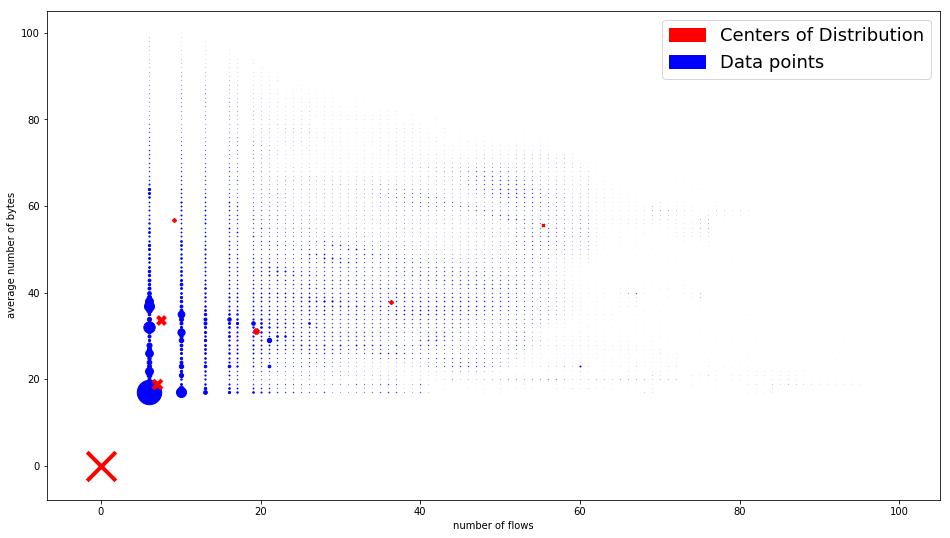

In [18]:
plot_points(groupped_data.values[:, :2], onlineEM)

In [9]:
from math import log
import scipy.stats.distributions


def poisson(x, l):
    return_value = 1
    for x_i, l_i in zip(x, l):
        return_value *= scipy.stats.distributions.poisson.pmf(x_i, l_i)
    return return_value

def calculate_likelihood_em(data, host_specific=False):
    # first reset previous point for all hosts for rerun

    previous_points = {}
    for host in onlineEM.hosts:
        previous_points[host] = onlineEM.hosts[host]['hard_previous']

    total_likelihood = []
    
    for point in data:
        host = point[-1]

        previous_point = previous_points[host]

        point_center = onlineEM.closest_centers([point])
        closest_center = np.argmax(point_center)

        previous_points[host] = closest_center
        
        if host_specific:
            probabilities = onlineEM.hosts[host]['transition_matrix'][previous_point]
        else:
            probabilities = onlineEM.hard_transition_matrix[previous_point]
    
        participation = probabilities * np.array([poisson(point, lambda_i) for lambda_i in onlineEM.lambdas])
        
        likelihood = log(np.sum(participation))
    
        total_likelihood.append(likelihood)

    return sum(total_likelihood) / len(total_likelihood)

In [48]:
# likelihood_train = calculate_likelihood_em(groupped_data.values[:,[0,1,3]])
# print(likelihood_train)

likelihood_test = calculate_likelihood_em(groupped_data1.values[:test*100,[0,1,3]])
print(likelihood_test)

-3.553397552386538


In [ ]:
# likelihood_train_host = calculate_likelihood_em(groupped_data.values[:,[0,1,3]], host_specific=True)
# print(likelihood_train_host)

likelihood_test_host = calculate_likelihood_em(groupped_data1.values[:len(hosts)*100,[0,1,3]], host_specific=True)
print(likelihood_test_host)

In [ ]:
likelihood_train_host = calculate_likelihood_em(groupped_data.values[:,[0,1,3]], host_specific=True)
print(likelihood_train_host)

In [49]:
likelihood_test = calculate_likelihood_em(groupped_data1.values[:test*100,[0,1,3]])
print(likelihood_test)

-3.553397552386538


In [50]:
likelihood_test_host = calculate_likelihood_em(groupped_data1.values[:test*100,[0,1,3]], host_specific=True)
print(likelihood_test_host)

-3.253308755015313


In [19]:
onlineEM.calculate_likelihood(groupped_data1.values[:,[0,1,3]]) / len(groupped_data1.values[:,[0,1,3]])

-1.694035111864921

In [47]:
print(onlineEM.lambdas)
print(onlineEM.gammas)

[[7.490530257660513 33.61984253955143]
 [55.35796116568266 55.5106133016459]
 [0.0 0.0]
 [9.192336417675378 56.81490528692768]
 [19.384708222786813 31.1284045736644]
 [36.29728398378874 37.89205204878816]
 [7.0770611843650215 18.8042149465344]]
[ 0.06432335  0.0017334   0.82177117  0.005839    0.0196199   0.00671074
  0.08000244]


In [48]:
temp = onlineEM.lambdas[0].copy()
onlineEM.lambdas[0] = onlineEM.lambdas[2]
onlineEM.lambdas[2] = temp

temp = onlineEM.gammas[0].copy()
onlineEM.gammas[0] = onlineEM.gammas[2]
onlineEM.gammas[2] = temp

In [49]:
print(onlineEM.lambdas)
print(onlineEM.gammas)

[[0.0 0.0]
 [55.35796116568266 55.5106133016459]
 [7.490530257660513 33.61984253955143]
 [9.192336417675378 56.81490528692768]
 [19.384708222786813 31.1284045736644]
 [36.29728398378874 37.89205204878816]
 [7.0770611843650215 18.8042149465344]]
[ 0.82177117  0.0017334   0.06432335  0.005839    0.0196199   0.00671074
  0.08000244]


In [59]:
kplusplus.centers

[array([6, 32], dtype=object),
 array([58, 54], dtype=object),
 array([0, 0], dtype=object),
 array([13, 77], dtype=object),
 array([26, 33], dtype=object),
 array([60, 23], dtype=object),
 array([10, 17], dtype=object)]

In [50]:
print(onlineEM.hard_transition_matrix)
print(onlineEM.hard_points_per_EM_cluster)

[[  2.43944633e-01   1.98368769e-05   6.04063616e-01   1.08523714e-02
    3.05145558e-02   2.19229485e-03   1.08412692e-01]
 [  8.36391781e-04   8.54043393e-01   9.86193294e-04   1.11851796e-02
    7.50255911e-03   1.24360223e-01   1.08606097e-03]
 [  6.44593881e-02   5.01944820e-06   8.28744173e-01   1.95229942e-03
    1.31934368e-02   9.53728400e-04   9.06919552e-02]
 [  1.26374278e-01   2.40741932e-03   1.77028276e-01   5.64900436e-01
    5.67487311e-02   8.20757304e-03   6.43332871e-02]
 [  1.08750374e-01   5.76176325e-04   4.04254824e-01   1.73011478e-02
    3.25024765e-01   2.69047914e-02   1.17187921e-01]
 [  2.47677166e-02   3.09129748e-02   7.07990060e-02   6.83996621e-03
    8.90021912e-02   7.59618798e-01   1.80593470e-02]
 [  6.35997583e-02   2.81611984e-05   6.47701792e-01   3.77590888e-03
    2.30206255e-02   1.19685093e-03   2.60676903e-01]]
[  3125492.     80106.  30082988.    295337.    945891.    326756.
   4332202.]


In [51]:
temp = onlineEM.hard_transition_matrix[0].copy()
onlineEM.hard_transition_matrix[0] = onlineEM.hard_transition_matrix[2]
onlineEM.hard_transition_matrix[2] = temp

for t in onlineEM.hard_transition_matrix:
    temp = t[2]
    t[2] = t[0]
    t[0] = temp

In [52]:
temp = onlineEM.hard_points_per_EM_cluster[0].copy()
onlineEM.hard_points_per_EM_cluster[0] = onlineEM.hard_points_per_EM_cluster[2]
onlineEM.hard_points_per_EM_cluster[2] = temp

In [53]:
print(onlineEM.hard_transition_matrix)
print(onlineEM.hard_points_per_EM_cluster)

[[  8.28744173e-01   5.01944820e-06   6.44593881e-02   1.95229942e-03
    1.31934368e-02   9.53728400e-04   9.06919552e-02]
 [  9.86193294e-04   8.54043393e-01   8.36391781e-04   1.11851796e-02
    7.50255911e-03   1.24360223e-01   1.08606097e-03]
 [  6.04063616e-01   1.98368769e-05   2.43944633e-01   1.08523714e-02
    3.05145558e-02   2.19229485e-03   1.08412692e-01]
 [  1.77028276e-01   2.40741932e-03   1.26374278e-01   5.64900436e-01
    5.67487311e-02   8.20757304e-03   6.43332871e-02]
 [  4.04254824e-01   5.76176325e-04   1.08750374e-01   1.73011478e-02
    3.25024765e-01   2.69047914e-02   1.17187921e-01]
 [  7.07990060e-02   3.09129748e-02   2.47677166e-02   6.83996621e-03
    8.90021912e-02   7.59618798e-01   1.80593470e-02]
 [  6.47701792e-01   2.81611984e-05   6.35997583e-02   3.77590888e-03
    2.30206255e-02   1.19685093e-03   2.60676903e-01]]
[ 30082988.     80106.   3125492.    295337.    945891.    326756.
   4332202.]


In [54]:
host = 'C4797'
print(onlineEM.hosts[host]['points_per_cluster'])
print(onlineEM.hosts[host]['transition_matrix'])

[  0.00000000e+00   0.00000000e+00   8.31800000e+03   0.00000000e+00
   8.96000000e+03   0.00000000e+00   1.00000000e+00]
[[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   9.20894446e-02   0.00000000e+00
    9.07790334e-01   0.00000000e+00   1.20221207e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   8.42633929e-01   0.00000000e+00
    1.57366071e-01   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]]


In [55]:
for host in onlineEM.hosts:
    
    temp = onlineEM.hosts[host]['transition_matrix'][0].copy()
    onlineEM.hosts[host]['transition_matrix'][0] = onlineEM.hosts[host]['transition_matrix'][2]
    onlineEM.hosts[host]['transition_matrix'][2] = temp

    for t in onlineEM.hosts[host]['transition_matrix']:
        temp = t[2]
        t[2] = t[0]
        t[0] = temp
    
    temp = onlineEM.hosts[host]['points_per_cluster'][0].copy()
    onlineEM.hosts[host]['points_per_cluster'][0] = onlineEM.hosts[host]['points_per_cluster'][2]
    onlineEM.hosts[host]['points_per_cluster'][2] = temp

In [57]:
host = 'C4797'
print(onlineEM.hosts[host]['points_per_cluster'])
print(onlineEM.hosts[host]['transition_matrix'])

[  8.31800000e+03   0.00000000e+00   0.00000000e+00   0.00000000e+00
   8.96000000e+03   0.00000000e+00   1.00000000e+00]
[[  9.20894446e-02   0.00000000e+00   0.00000000e+00   0.00000000e+00
    9.07790334e-01   0.00000000e+00   1.20221207e-04]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  8.42633929e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.57366071e-01   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]]
